In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import mudata as md
import networkx as nx
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from utils.gglasso_pipeline import gg_lasso_network_analysis
from gglasso.problem import glasso_problem
from utils.utils import calc_sparsity, plot_lambda1_path
from gglasso.helper.basic_linalg import scale_array_by_diagonal
from scipy.cluster.hierarchy import linkage
from latentcor import latentcor

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

### EC

In [2]:
ec_mudata = md.read("../data/preprocessed/ec_mudata_preprocessed.h5mu")
ec_mudata

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


MuData object with n_obs × n_vars = 2507 × 2919
  3 modalities
    all_genes:	2507 x 2622
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
    gc1_genes:	2507 x 245
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
    gc5_genes:	2504 x 52
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [3]:
print("Sparsity:\t\t", calc_sparsity(ec_mudata["gc5_genes"].X.A))
print("Mean counts per gene:\t", np.mean(np.sum(ec_mudata["gc5_genes"].X.A, axis=1)))
print("Median counts per gene:\t", np.median(np.sum(ec_mudata["gc5_genes"].X.A, axis=1)))
print("Mean genes per cell: \t", np.mean(np.sum(ec_mudata["gc5_genes"].X.A, axis=0)))
print("Median genes per cell:\t", np.median(np.sum(ec_mudata["gc5_genes"].X.A, axis=0)))

Sparsity:		 0.8612066846891128
Mean counts per gene:	 8.711262
Median counts per gene:	 7.0
Mean genes per cell: 	 419.48077
Median genes per cell:	 322.0


### Datasets

In [4]:
ec_mrna_gc5 = ec_mudata["gc5_genes"][:, ~ec_mudata["gc5_genes"].var["rRNA"]].copy()
ec_mrna_gc5

AnnData object with n_obs × n_vars = 2504 × 24
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [5]:
ec_rrna_gc5 = ec_mudata["gc5_genes"][:, ec_mudata["gc5_genes"].var["rRNA"]].copy()
ec_rrna_gc5

AnnData object with n_obs × n_vars = 2504 × 28
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [6]:
ec_mrna_gc1 = ec_mudata["gc1_genes"][:, ~ec_mudata["gc1_genes"].var["rRNA"]].copy()
ec_mrna_gc1

AnnData object with n_obs × n_vars = 2507 × 204
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [7]:
ec_rrna_gc1 = ec_mudata["gc1_genes"][:, ec_mudata["gc1_genes"].var["rRNA"]].copy()
ec_rrna_gc1

AnnData object with n_obs × n_vars = 2507 × 41
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

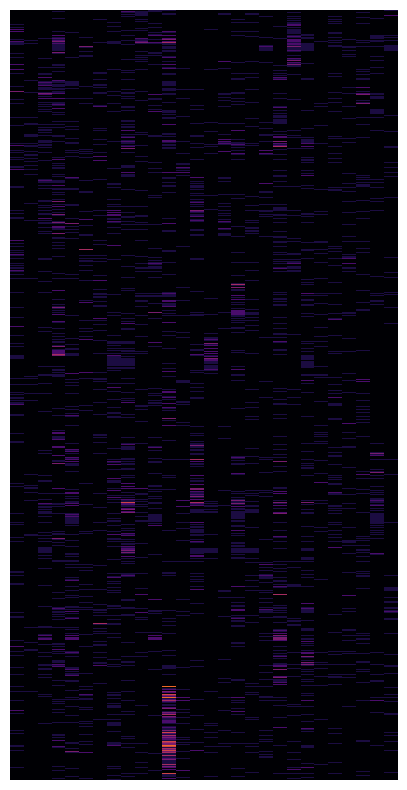

In [79]:
# plt heatmap of ec_rrna_gc5.X.A
plt.figure(figsize=(5, 10))
sns.heatmap(ec_rrna_gc5.X.A, cmap="inferno", xticklabels=False, yticklabels=False, cbar=False)
#plt.title("rRNA counts in EC GC5")
plt.show()

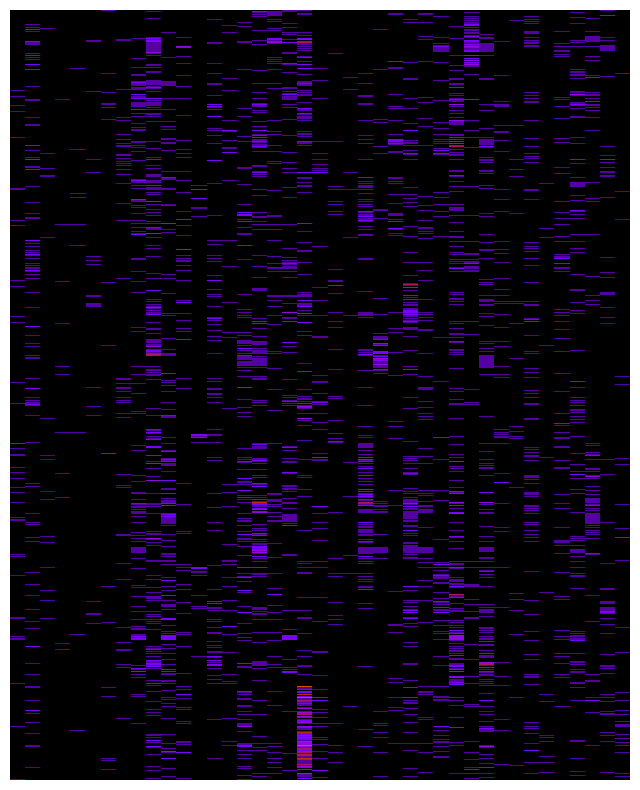

In [72]:
# plt heatmap of ec_rrna_gc5.X.A
plt.figure(figsize=(8, 10))
sns.heatmap(ec_rrna_gc1.X.A, cmap="gnuplot", xticklabels=False, yticklabels=False, cbar=False)
#plt.title("rRNA counts in EC GC5")
plt.show()

### GC5: latentcor + GGL

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


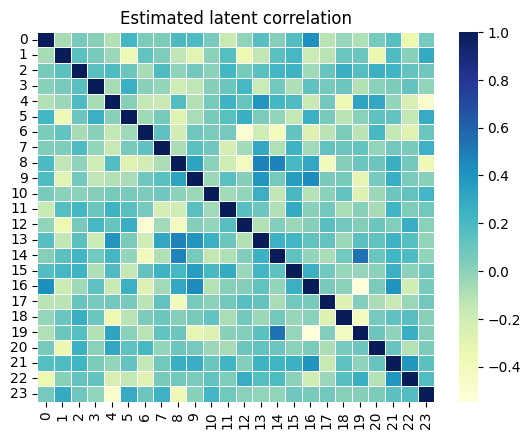

In [8]:
tps = ['tru' for i in range(ec_mrna_gc5.shape[1])]
ec_est_mrna_gc5 = latentcor(ec_mrna_gc5.layers['sqrt_counts'].A, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=True)

In [11]:
np.save("../data/latent_est/4S/ec_est_gc5.npy", ec_est_mrna_gc5)

In [22]:
ec_est_mrna_gc5 = np.load("../data/latent_est/4S/ec_est_gc5.npy", allow_pickle=True).item()

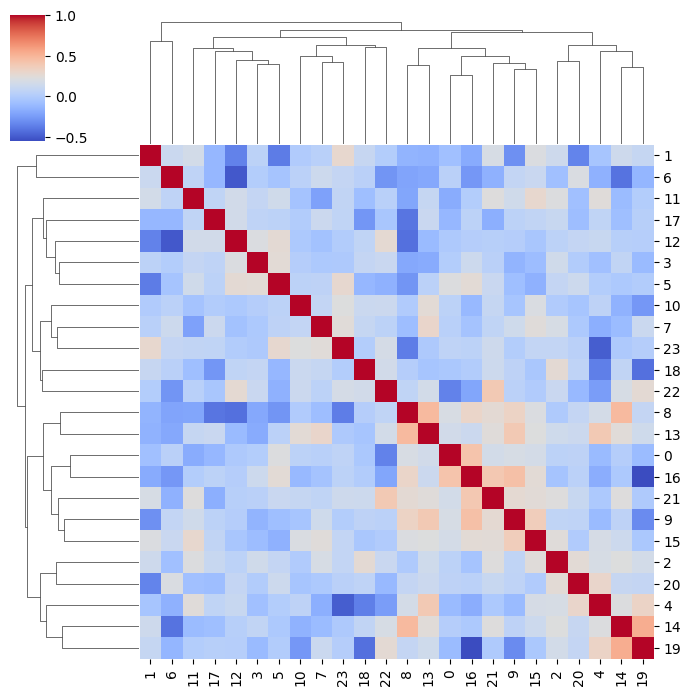

In [23]:
sns.clustermap(ec_est_mrna_gc5['R'], cmap='coolwarm', figsize=(7, 7))

In [24]:
ec_mrna_gc5_link = linkage(y=ec_est_mrna_gc5['R'], method="average", metric="euclidean")

In [73]:
ec_ggl_gc5 = gg_lasso_network_analysis(N=ec_mrna_gc5.shape[0], estimate=ec_est_mrna_gc5)
ec_ggl_gc5.create_problem(S_col="R", latent=False)
ec_ggl_gc5.model_selection(lambda1_range=np.logspace(0, -6, 100), gamma=0.1)

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 35 iterations with status: optimal.
ADMM terminated after 38 iterations with status: optimal.
ADMM terminated after 41 iterations with status: optimal.
ADMM terminated after 35 iterations with status: optimal.
ADMM terminated after 52 iterations wi

In [74]:
ec_sol_gc5 = ec_ggl_gc5.P.solution.precision_

In [93]:
np.save("../data/model_selec_dicts/4S/ec_mrna_gc5_lc", ec_ggl_gc5.P.__dict__)

In [99]:
np.save("../data/precision_matrices/4S/ec_mrna_gc5_lc", ec_sol_gc5)

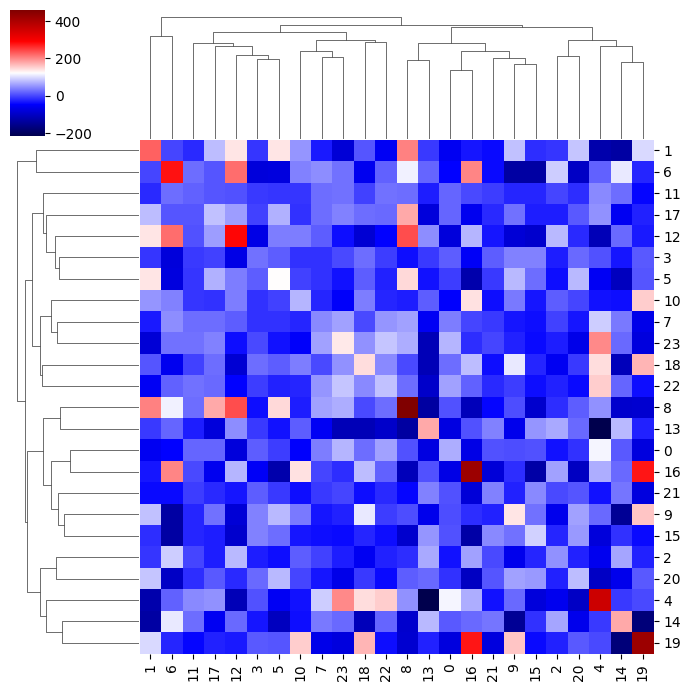

In [78]:
sns.clustermap(ec_sol_gc5, cmap="seismic", col_linkage=ec_mrna_gc5_link, row_linkage=ec_mrna_gc5_link, figsize=(7, 7))

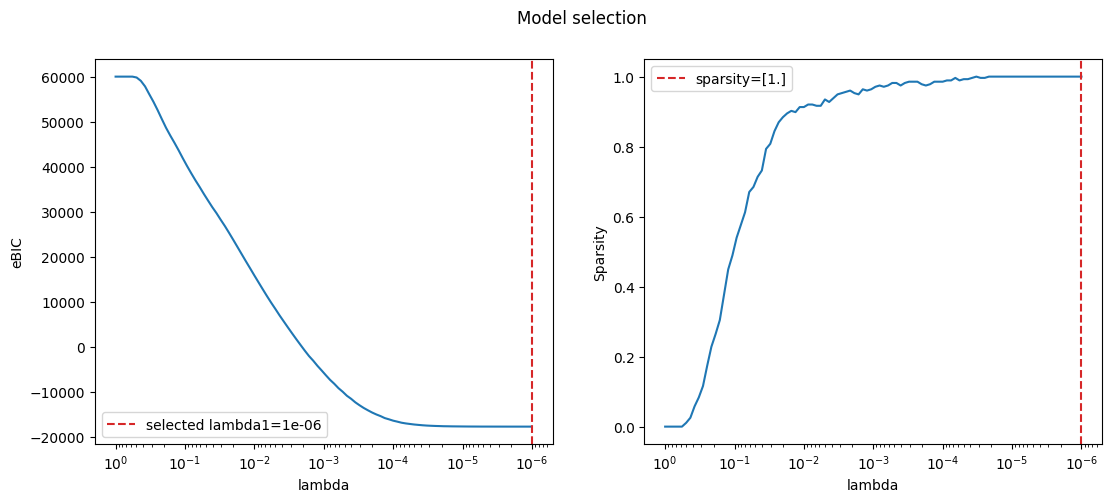

In [76]:
P_dict_gc5_mrna = ec_ggl_gc5.P.__dict__

lambda1_gc5_mrna = P_dict_gc5_mrna["reg_params"]["lambda1"]
lambda1_range = P_dict_gc5_mrna["modelselect_params"]["lambda1_range"]
sparsity_gc5_mrna = P_dict_gc5_mrna["modelselect_stats"]["SP"]
eBIC_gc5_mrna = P_dict_gc5_mrna["modelselect_stats"]["BIC"][0.1]

fig, axs = plt.subplots(1, 2, figsize=(13, 5))

sns.lineplot(x=lambda1_range, y=eBIC_gc5_mrna.squeeze(), ax=axs[0])
axs[0].axvline(x=lambda1_gc5_mrna, ls="--", color="C3", label=f"selected lambda1={np.round(lambda1_gc5_mrna, 7)}")
axs[0].set_xscale("log")
axs[0].set_xlabel("lambda")
axs[0].set_ylabel("eBIC")
axs[0].invert_xaxis()
axs[0].legend()

sns.lineplot(x=lambda1_range, y=sparsity_gc5_mrna.squeeze(), ax=axs[1])
axs[1].axvline(x=lambda1_gc5_mrna, ls="--", color="C3", label=f"sparsity={sparsity_gc5_mrna[np.where(lambda1_range == lambda1_gc5_mrna)[0][0]]}")
axs[1].set_xscale("log")
axs[1].set_xlabel("lambda")
axs[1].set_ylabel("Sparsity")
axs[1].invert_xaxis()
axs[1].legend()
plt.suptitle("Model selection")
plt.show()

In [77]:
#number of nodes
print("nodes:", ec_sol_gc5.shape[0])
#number of edges
print("edges:", np.count_nonzero(np.triu(ec_sol_gc5, k=1)))
#ebic value
print("ebic:", eBIC_gc5_mrna[np.where(lambda1_range == lambda1_gc5_mrna)[0][0]])

nodes: 24
edges: 276
ebic: [-17794.6437898]


### GC1: latentcor + GGL

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


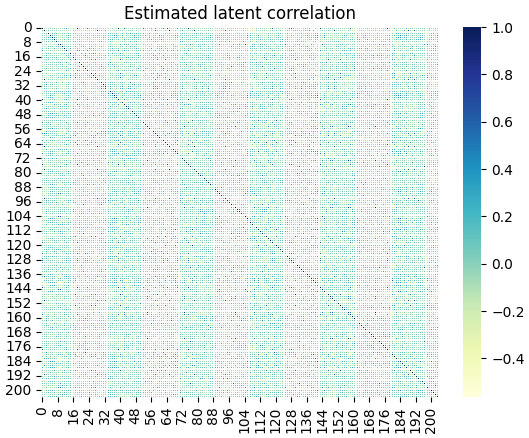

In [75]:
#tps = ['tru' for i in range(ec_mrna_gc1.shape[1])]
# ec_est_mrna_gc1 = latentcor(ec_mrna_gc1.layers['sqrt_counts'].A, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=True)

In [ ]:
# np.save("../data/latent_est/4S/ec_est_gc1.npy", ec_est_mrna_gc1)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


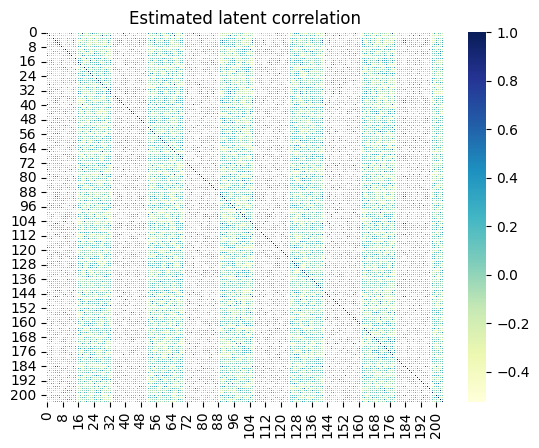

In [42]:
#method = original
# tps = ['tru' for i in range(ec_mrna_gc1.shape[1])]
# ec_est_mrna_gc1 = latentcor(ec_mrna_gc1.layers['sqrt_counts'].A, tps=tps, method='original', use_nearPD=True, nu=0.001, showplot=True)

In [43]:
# np.save("../data/latent_est/4S/ec_est_gc1_original.npy", ec_est_mrna_gc1)

In [35]:
ec_est_mrna_gc1 = np.load("../data/latent_est/4S/ec_est_gc1.npy", allow_pickle=True).item()

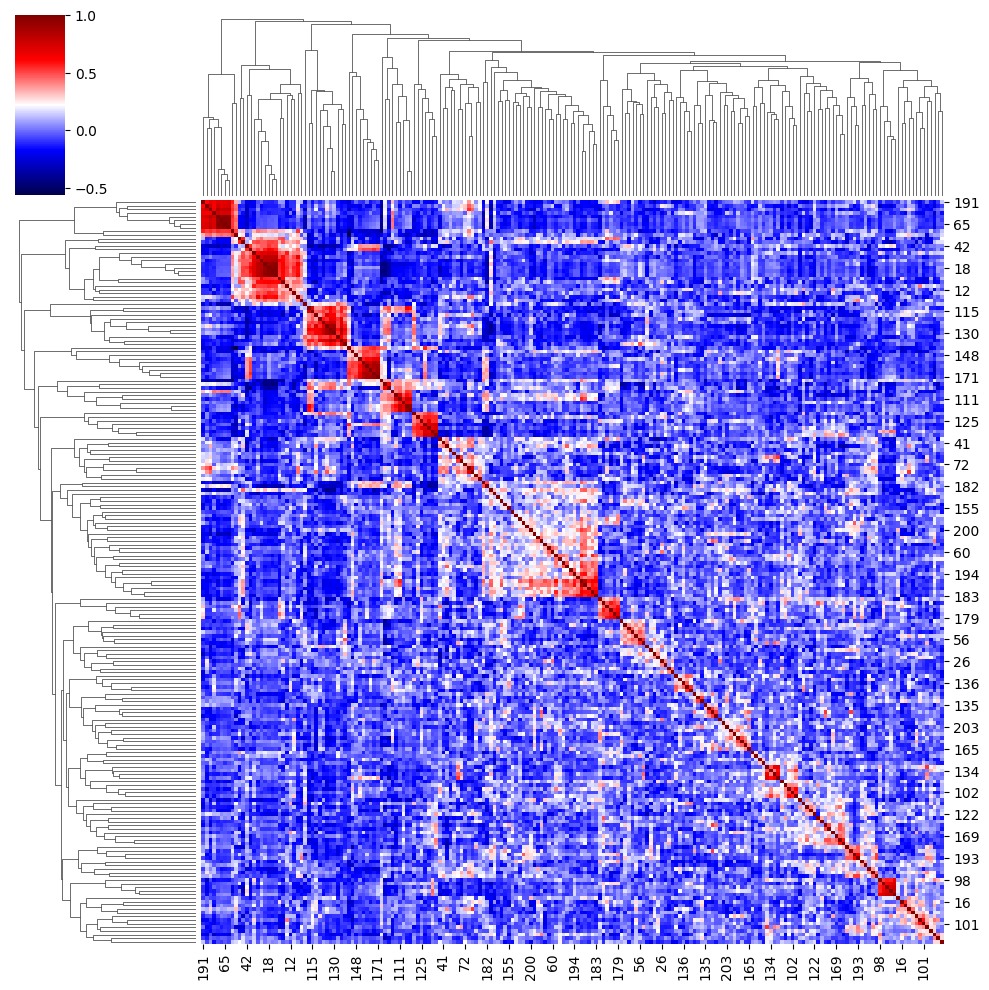

In [36]:
cm = sns.clustermap(ec_est_mrna_gc1['R'], cmap='seismic', figsize=(10, 10))

In [98]:
ec_est_mrna_gc1['R'].min().min()

-0.561997027410083

In [37]:
ec_mrna_gc1_link = linkage(y=ec_est_mrna_gc1['R'], method="average", metric="euclidean")

In [71]:
#get new indices of the clustermap cm
new_indices = cm.dendrogram_row.reordered_ind
#reorder the matrix
lc_reordered = ec_est_mrna_gc1['R'].to_numpy()
lc_reordered = lc_reordered[new_indices, :]
lc_reordered = lc_reordered[:, new_indices]
lc_reordered.shape

(204, 204)

In [75]:
labels_full = ec_mrna_gc1.var["protein_name"].values[new_indices]
labels_full = [label.split("[")[0] for label in labels_full]
labels_full[0]

'NP_313162.1 anaerobic fumarate reductase catalytic and NAD/flavoprotein subunit '

In [78]:
labels_prot = [label.split(" ")[0] for label in labels_full]
labels_prot[0]

'NP_313162.1'

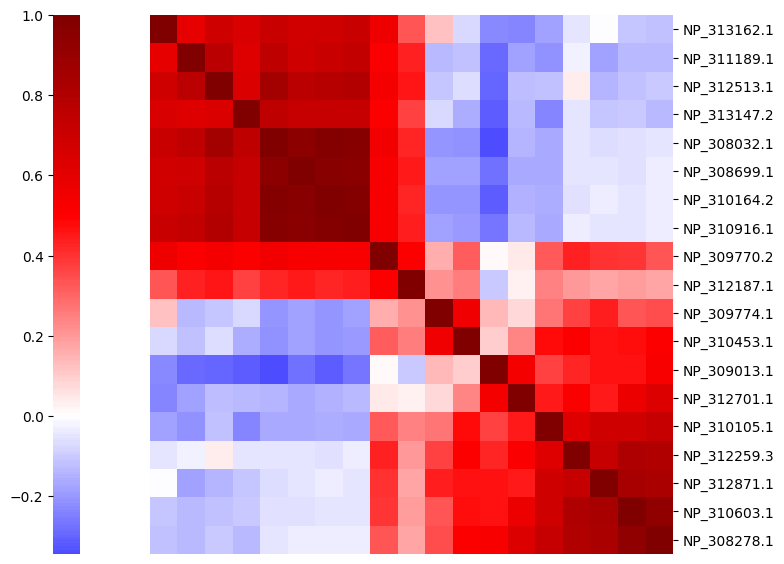

In [90]:
plt.figure(figsize=(9, 7))
sns.heatmap(lc_reordered[:19, :19], cmap='seismic', center=0, xticklabels=False, yticklabels=labels_prot[:19], cbar=True, cbar_kws={"location": "left"})
plt.tick_params(axis='y', right=True, left= False, labelright=True, labelleft=False, labelrotation=0)
plt.show()

In [38]:
ec_ggl_gc1 = gg_lasso_network_analysis(N=ec_mrna_gc1.shape[0], estimate=ec_est_mrna_gc1)
ec_ggl_gc1.create_problem(S_col="R", latent=False)
ec_ggl_gc1.model_selection(lambda1_range=np.logspace(0, -6, 100), gamma=0.1)

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 25 iterations wi

In [39]:
ec_sol_gc1 = ec_ggl_gc1.P.solution.precision_

In [94]:
np.save("../data/model_selec_dicts/4S/ec_mrna_gc1_lc", ec_ggl_gc1.P.__dict__)

In [100]:
np.save("../data/precision_matrices/4S/ec_mrna_gc1_lc", ec_sol_gc1)

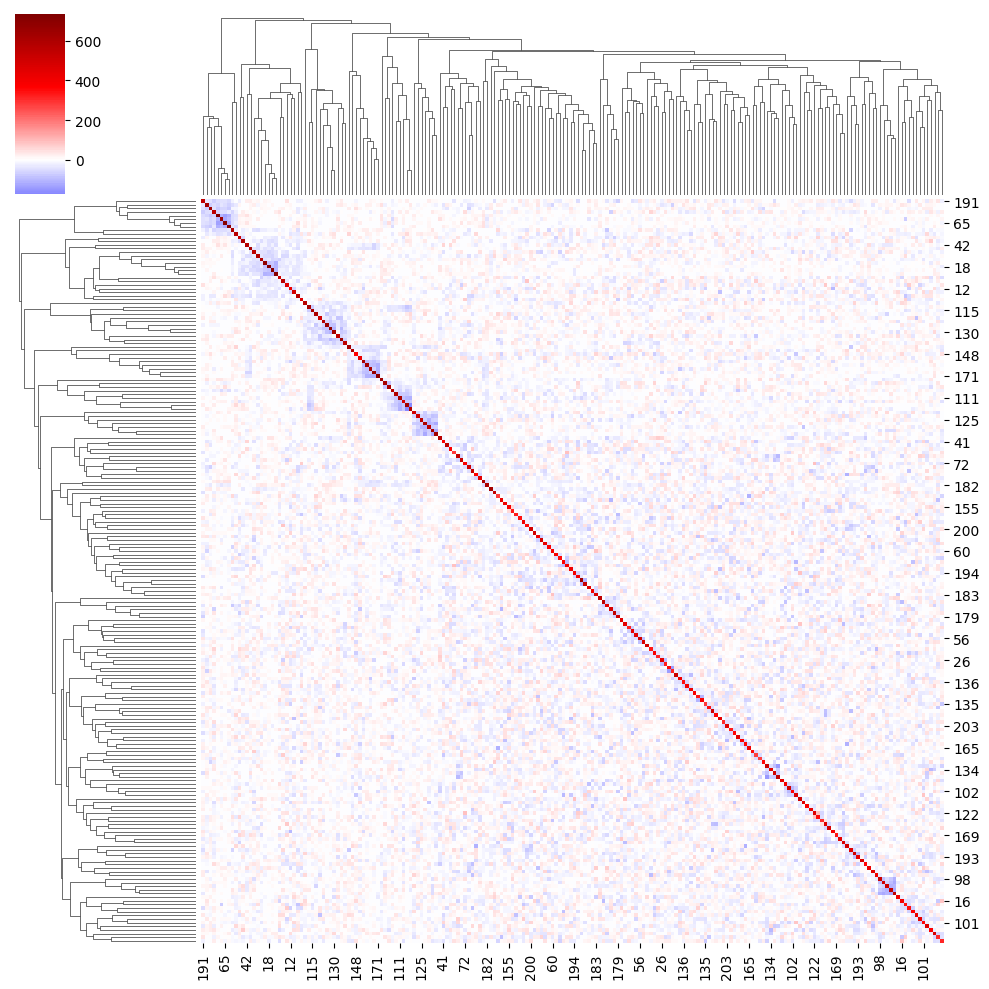

In [40]:
sns.clustermap(ec_sol_gc1, cmap="seismic", col_linkage=ec_mrna_gc1_link, row_linkage=ec_mrna_gc1_link, figsize=(10, 10), center=0)

In [83]:
ec_sol_gc1_reord = ec_sol_gc1[new_indices, :]
ec_sol_gc1_reord = ec_sol_gc1_reord[:, new_indices]
ec_sol_gc1_reord.shape

(204, 204)

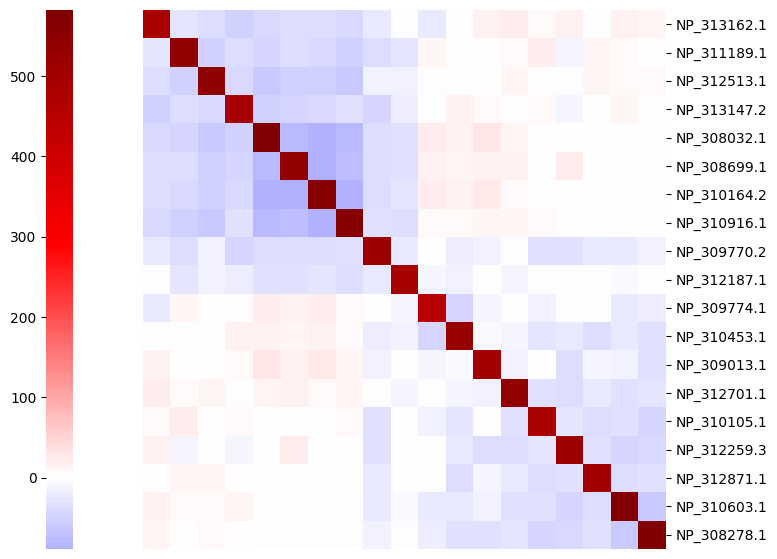

In [89]:
plt.figure(figsize=(9, 7))
sns.heatmap(ec_sol_gc1_reord[:19, :19], cmap='seismic', center=0, xticklabels=False, yticklabels=labels_prot[:19], cbar=True, cbar_kws={"location": "left"})
plt.tick_params(axis='y', right=True, left= False, labelright=True, labelleft=False, labelrotation=0)
plt.show()

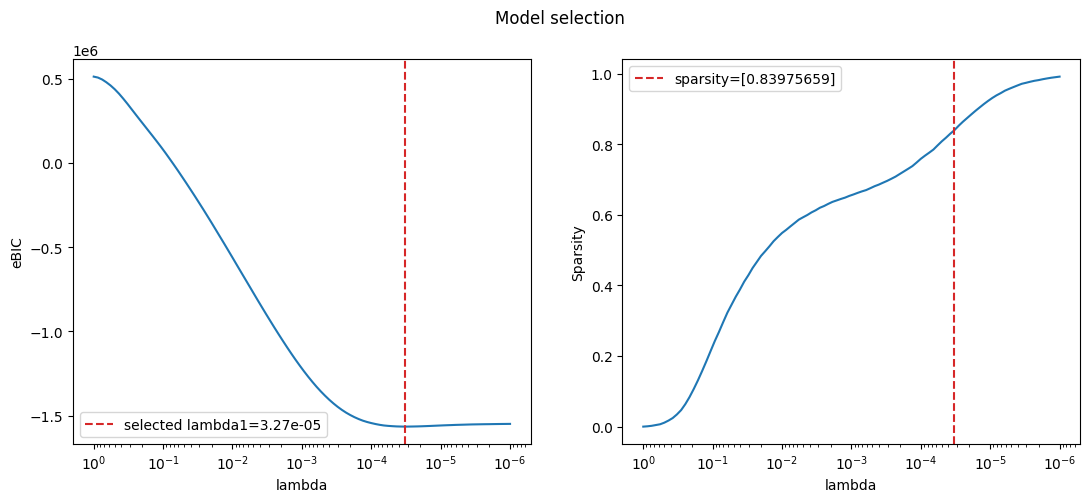

In [41]:
P_dict_gc1_mrna = ec_ggl_gc1.P.__dict__

lambda1_gc1_mrna = P_dict_gc1_mrna["reg_params"]["lambda1"]
lambda1_range = P_dict_gc1_mrna["modelselect_params"]["lambda1_range"]
sparsity_gc1_mrna = P_dict_gc1_mrna["modelselect_stats"]["SP"]
eBIC_gc1_mrna = P_dict_gc1_mrna["modelselect_stats"]["BIC"][0.1]

fig, axs = plt.subplots(1, 2, figsize=(13, 5))

sns.lineplot(x=lambda1_range, y=eBIC_gc1_mrna.squeeze(), ax=axs[0])
axs[0].axvline(x=lambda1_gc1_mrna, ls="--", color="C3", label=f"selected lambda1={np.round(lambda1_gc1_mrna, 7)}")
axs[0].set_xscale("log")
axs[0].set_xlabel("lambda")
axs[0].set_ylabel("eBIC")
axs[0].invert_xaxis()
axs[0].legend()

sns.lineplot(x=lambda1_range, y=sparsity_gc1_mrna.squeeze(), ax=axs[1])
axs[1].axvline(x=lambda1_gc1_mrna, ls="--", color="C3", label=f"sparsity={sparsity_gc1_mrna[np.where(lambda1_range == lambda1_gc1_mrna)[0][0]]}")
axs[1].set_xscale("log")
axs[1].set_xlabel("lambda")
axs[1].set_ylabel("Sparsity")
axs[1].invert_xaxis()
axs[1].legend()
plt.suptitle("Model selection")
plt.show()

In [53]:
#number of nodes
print("nodes:", ec_sol_gc1.shape[0])
#number of edges
print("edges:", np.count_nonzero(np.triu(ec_sol_gc1, k=1)))
#ebic value
print("ebic:", eBIC_gc1_mrna[np.where(lambda1_range == lambda1_gc1_mrna)[0][0]])

nodes: 204
edges: 17388
ebic: [-1564374.53277932]


In [22]:
mapping = pd.read_csv("../data/string/ec/string_mapping_ec.tsv", sep="\t")
mapping

#queryIndex                                        queryItem  \
0              2                        isoleucyl-tRNA synthetase   
1              4                       cell division protein FtsQ   
2              6     UDP-3-O-acyl N-acetylglucosamine deacetylase   
3              8                           pyruvate dehydrogenase   
4             11                                 uridylate kinase   
..           ...                                              ...   
111          194                             primosomal protein N   
112          195  anaerobic ribonucleoside-triphosphate reductase   
113          196                            magnesium transporter   
114          197                            valyl-tRNA synthetase   
115          199                  purine nucleoside phosphorylase   

                 stringId preferredName  \
0    386585.gene:10363007       ECs0029   
1    386585.gene:10363075       ECs0097   
2    386585.gene:10363078       ECs0100   
3    386585.gene:10363958       ECs0957   
4    386585.gene:10363151       ECs0173   
..                    ...           ...   
111  386585.gene:10367960       ECs4862   
112  386585.gene:10368330       ECs5215   
113  386585.gene:10367838       ECs4746   
114  386585.gene:10368350       ECs5235   
115  386585.gene:10368460       ECs5343   

                                            annotation  
0    Isoleucine tRNA synthetase; Similar to ILES_EC...  
1    Cell division protein FtsQ; Similar to FTSQ_EC...  
2    UDP-3-O-acyl N-acetylglucosamine deacetylase; ...  
3    Pyruvate oxidase; Similar to POXB_ECOLI gi|178...  
4    Uridylate kinase; Similar to PYRH_ECOLI gi|178...  
..                                                 ...  
111  Primosomal protein N; Similar to PRIA_ECOLI gi...  
112  Anaerobic ribonucleoside-triphosphate reductas...  
113  Mg2+ transport protein CorA; Similar to CORA_E...  
114  Valine tRNA synthetase; Similar to VALS_ECOLI ...  
115  Purine-nucleoside phosphorylase; Similar to DE...  

[116 rows x 5 columns]

In [23]:
for i, row in mapping.iterrows():
    query = row["queryItem"]
    target_index = ec_mrna_gc1.var.loc[ec_mrna_gc1.var["protein_name"].str.contains(query)].index
    for i in target_index:
        ec_mrna_gc1.var.loc[i, "string_id"] = row["stringId"]
ec_mrna_gc1.var.head()

/tmp/ipykernel_17473/2386068935.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  target_index = ec_mrna_gc1.var.loc[ec_mrna_gc1.var["protein_name"].str.contains(query)].index


strains matchin_protein      protein  \
cds-ECs_2323     GSM5456504_Efm_CDS        no_match     no_match   
cds-NP_308032.1  GSM5456505_PsA_CDS           match  NP_308032.1   
cds-NP_308056.1  GSM5456505_PsA_CDS           match  NP_308056.1   
cds-NP_308086.1  GSM5456505_PsA_CDS           match  NP_308086.1   
cds-NP_308124.1  GSM5456505_PsA_CDS           match  NP_308124.1   

                 n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
cds-ECs_2323                    40     0.015955              98.404467   
cds-NP_308032.1                 42     0.016753              98.324691   
cds-NP_308056.1                 86     0.035899              96.569605   
cds-NP_308086.1                 63     0.025529              97.487036   
cds-NP_308124.1                 28     0.011169              98.883127   

                 total_counts  n_cells  \
cds-ECs_2323             40.0       52   
cds-NP_308032.1          42.0       49   
cds-NP_308056.1          90.0      155   
cds-NP_308086.1          64.0      128   
cds-NP_308124.1          28.0       62   

                                                      protein_name   rRNA  \
cds-ECs_2323                                                  None  False   
cds-NP_308032.1  NP_308032.1 hypothetical protein ECs_0005 [Esc...  False   
cds-NP_308056.1  NP_308056.1 isoleucyl-tRNA synthetase [Escheri...  False   
cds-NP_308086.1  NP_308086.1 LPS assembly OM complex LptDE beta...  False   
cds-NP_308124.1  NP_308124.1 cell division protein FtsQ [Escher...  False   

                 ...        PC_lev1        PC_lev2        PC_lev3  \
cds-ECs_2323     ...       no_match       no_match       no_match   
cds-NP_308032.1  ...  forDFlev13644  forDFlev23644  forDFlev33644   
cds-NP_308056.1  ...  forDFlev11003  forDFlev21003  forDFlev31003   
cds-NP_308086.1  ...  forDFlev14464  forDFlev24464  forDFlev34464   
cds-NP_308124.1  ...   forDFlev1336   forDFlev2336   forDFlev3336   

                       PC_lev4        PC_lev5        PC_lev6  \
cds-ECs_2323          no_match       no_match       no_match   
cds-NP_308032.1  forDFlev43644  forDFlev53644  forDFlev63644   
cds-NP_308056.1  forDFlev41003  forDFlev51003  forDFlev61003   
cds-NP_308086.1  forDFlev44464  forDFlev54464  forDFlev64464   
cds-NP_308124.1   forDFlev4336   forDFlev5336   forDFlev6336   

                log1p_mean_counts  log1p_total_counts  n_counts  \
cds-ECs_2323             0.015829            3.713572      40.0   
cds-NP_308032.1          0.016614            3.761200      42.0   
cds-NP_308056.1          0.035270            4.510859      90.0   
cds-NP_308086.1          0.025208            4.174387      64.0   
cds-NP_308124.1          0.011107            3.367296      28.0   

                            string_id  
cds-ECs_2323                      nan  
cds-NP_308032.1                   nan  
cds-NP_308056.1  386585.gene:10363668  
cds-NP_308086.1                   nan  
cds-NP_308124.1  386585.gene:10363075  

[5 rows x 21 columns]

In [24]:
interactions = pd.read_csv("../data/string/ec/string_interactions_short_ec.tsv", sep="\t")
interactions

#node1    node2       node1_string_id       node2_string_id  \
0    ECs0029  ECs1846  386585.gene:10363007  386585.gene:10364862   
1    ECs0029  ECs2426  386585.gene:10363007  386585.gene:10365455   
2    ECs0029  ECs2346  386585.gene:10363007  386585.gene:10365373   
3    ECs0029  ECs2420  386585.gene:10363007  386585.gene:10365449   
4    ECs0029  ECs2920  386585.gene:10363007  386585.gene:10365961   
..       ...      ...                   ...                   ...   
222  ECs4716  ECs5155  386585.gene:10367802  386585.gene:10368270   
223  ECs4716  ECs4911  386585.gene:10367802  386585.gene:10368018   
224  ECs4716  ECs4910  386585.gene:10367802  386585.gene:10368017   
225  ECs4910  ECs5124  386585.gene:10368017  386585.gene:10368236   
226  ECs4910  ECs4911  386585.gene:10368017  386585.gene:10368018   

     neighborhood_on_chromosome  gene_fusion  phylogenetic_cooccurrence  \
0                             0            0                          0   
1                             0            0                          0   
2                             0            0                          0   
3                             0            0                          0   
4                             0            0                          0   
..                          ...          ...                        ...   
222                           0            0                          0   
223                           0            0                          0   
224                           0            0                          0   
225                           0            0                          0   
226                           0            0                          0   

     homology  coexpression  experimentally_determined_interaction  \
0       0.000             0                                  0.000   
1       0.000             0                                  0.180   
2       0.000             0                                  0.000   
3       0.000             0                                  0.209   
4       0.605             0                                  0.570   
..        ...           ...                                    ...   
222     0.000             0                                  0.000   
223     0.000             0                                  0.782   
224     0.000             0                                  0.784   
225     0.000             0                                  0.092   
226     0.000             0                                  0.999   

     database_annotated  automated_textmining  combined_score  
0                 0.000                 0.414           0.414  
1                 0.000                 0.828           0.852  
2                 0.000                 0.816           0.816  
3                 0.000                 0.512           0.597  
4                 0.663                 0.512           0.923  
..                  ...                   ...             ...  
222               0.000                 0.551           0.551  
223               0.000                 0.227           0.824  
224               0.000                 0.292           0.840  
225               0.000                 0.689           0.705  
226               0.773                 0.999           0.999  

[227 rows x 13 columns]

In [25]:
# add a new col to ec_mrna_gc1.var named "protein_name_short" where the column "protein_name" is split by "[" and only the first part is taken

ec_mrna_gc1.var["protein_name_short"] = ec_mrna_gc1.var["protein_name"].str.split("[").str[0]
# split the protein names by " " and take everything after the first element but join them back together
ec_mrna_gc1.var["protein_name_short"] = ec_mrna_gc1.var["protein_name_short"].str.split(" ").str[1:].str.join(" ")
ec_mrna_gc1.var.head()

strains matchin_protein      protein  \
cds-ECs_2323     GSM5456504_Efm_CDS        no_match     no_match   
cds-NP_308032.1  GSM5456505_PsA_CDS           match  NP_308032.1   
cds-NP_308056.1  GSM5456505_PsA_CDS           match  NP_308056.1   
cds-NP_308086.1  GSM5456505_PsA_CDS           match  NP_308086.1   
cds-NP_308124.1  GSM5456505_PsA_CDS           match  NP_308124.1   

                 n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
cds-ECs_2323                    40     0.015955              98.404467   
cds-NP_308032.1                 42     0.016753              98.324691   
cds-NP_308056.1                 86     0.035899              96.569605   
cds-NP_308086.1                 63     0.025529              97.487036   
cds-NP_308124.1                 28     0.011169              98.883127   

                 total_counts  n_cells  \
cds-ECs_2323             40.0       52   
cds-NP_308032.1          42.0       49   
cds-NP_308056.1          90.0      155   
cds-NP_308086.1          64.0      128   
cds-NP_308124.1          28.0       62   

                                                      protein_name   rRNA  \
cds-ECs_2323                                                  None  False   
cds-NP_308032.1  NP_308032.1 hypothetical protein ECs_0005 [Esc...  False   
cds-NP_308056.1  NP_308056.1 isoleucyl-tRNA synthetase [Escheri...  False   
cds-NP_308086.1  NP_308086.1 LPS assembly OM complex LptDE beta...  False   
cds-NP_308124.1  NP_308124.1 cell division protein FtsQ [Escher...  False   

                 ...        PC_lev2        PC_lev3        PC_lev4  \
cds-ECs_2323     ...       no_match       no_match       no_match   
cds-NP_308032.1  ...  forDFlev23644  forDFlev33644  forDFlev43644   
cds-NP_308056.1  ...  forDFlev21003  forDFlev31003  forDFlev41003   
cds-NP_308086.1  ...  forDFlev24464  forDFlev34464  forDFlev44464   
cds-NP_308124.1  ...   forDFlev2336   forDFlev3336   forDFlev4336   

                       PC_lev5        PC_lev6 log1p_mean_counts  \
cds-ECs_2323          no_match       no_match          0.015829   
cds-NP_308032.1  forDFlev53644  forDFlev63644          0.016614   
cds-NP_308056.1  forDFlev51003  forDFlev61003          0.035270   
cds-NP_308086.1  forDFlev54464  forDFlev64464          0.025208   
cds-NP_308124.1   forDFlev5336   forDFlev6336          0.011107   

                log1p_total_counts  n_counts             string_id  \
cds-ECs_2323              3.713572      40.0                   nan   
cds-NP_308032.1           3.761200      42.0                   nan   
cds-NP_308056.1           4.510859      90.0  386585.gene:10363668   
cds-NP_308086.1           4.174387      64.0                   nan   
cds-NP_308124.1           3.367296      28.0  386585.gene:10363075   

                                                protein_name_short  
cds-ECs_2323                                                        
cds-NP_308032.1                     hypothetical protein ECs_0005   
cds-NP_308056.1                         isoleucyl-tRNA synthetase   
cds-NP_308086.1  LPS assembly OM complex LptDE beta-barrel comp...  
cds-NP_308124.1                        cell division protein FtsQ   

[5 rows x 22 columns]

In [26]:
n = ec_mrna_gc1.shape[1]
non_zero_entries = np.count_nonzero(ec_sol_gc1)
num_reported_interactions = 0

ec_G = nx.Graph()

for i in range(n):
    for j in range(i+1, n):
        if ec_sol_gc1[i, j] != 0:
            a = ec_mrna_gc1.var.iloc[i]["string_id"]
            b = ec_mrna_gc1.var.iloc[j]["string_id"]
            
            interaction_ab = interactions.loc[(interactions["node1_string_id"] == a) & (interactions["node2_string_id"] == b)]["combined_score"]
            interaction_ba = interactions.loc[(interactions["node1_string_id"] == b) & (interactions["node2_string_id"] == a)]["combined_score"]
            
            if len(interaction_ab) > 0 or len(interaction_ba) > 0:
                print(f"{ec_mrna_gc1.var.iloc[i]['protein_name_short']} - {ec_mrna_gc1.var.iloc[j]['protein_name_short']}")
                num_reported_interactions += 1

                ec_G.add_node(ec_mrna_gc1.var.iloc[i]['protein_name_short'], )
                ec_G.add_node(ec_mrna_gc1.var.iloc[j]['protein_name_short'])
                ec_G.add_edge(ec_mrna_gc1.var.iloc[i]['protein_name_short'], ec_mrna_gc1.var.iloc[j]['protein_name_short'], weight=ec_sol_gc1[i, j])

isoleucyl-tRNA synthetase  - DNA topoisomerase I 
isoleucyl-tRNA synthetase  - tyrosyl-tRNA synthetase 
isoleucyl-tRNA synthetase  - threonyl-tRNA synthetase 
isoleucyl-tRNA synthetase  - methionyl-tRNA synthetase 
isoleucyl-tRNA synthetase  - lysine tRNA synthetase 
isoleucyl-tRNA synthetase  - translation initiation factor IF-2 
isoleucyl-tRNA synthetase  - protein chain elongation factor EF-G 
isoleucyl-tRNA synthetase  - RNA polymerase beta subunit 
cell division protein FtsQ  - cell wall shape-determining protein 
cell division protein FtsQ  - penicillin-binding protein 2 
cell division protein FtsQ  - cell division protein FtsK 
cell division protein FtsQ  - cell division protein ZipA 
pyruvate dehydrogenase  - cytochrome d terminal oxidase subunit I 
pyruvate dehydrogenase  - cytochrome d terminal oxidase subunit II 
pyruvate dehydrogenase  - pyruvate kinase 
pyruvate dehydrogenase  - phosphate acetyltransferase 
uridylate kinase  - DNA topoisomerase I 
uridylate kinase  - pheny

In [32]:
ec_G.degree()

DegreeView({'isoleucyl-tRNA synthetase ': 8, 'DNA topoisomerase I ': 15, 'tyrosyl-tRNA synthetase ': 6, 'threonyl-tRNA synthetase ': 9, 'methionyl-tRNA synthetase ': 15, 'lysine tRNA synthetase ': 6, 'translation initiation factor IF-2 ': 18, 'protein chain elongation factor EF-G ': 9, 'RNA polymerase beta subunit ': 15, 'cell division protein FtsQ ': 4, 'cell wall shape-determining protein ': 2, 'penicillin-binding protein 2 ': 2, 'cell division protein FtsK ': 3, 'cell division protein ZipA ': 2, 'pyruvate dehydrogenase ': 4, 'cytochrome d terminal oxidase subunit I ': 4, 'cytochrome d terminal oxidase subunit II ': 4, 'pyruvate kinase ': 7, 'phosphate acetyltransferase ': 4, 'uridylate kinase ': 2, 'phenylalanine tRNA synthetase beta subunit ': 15, 'ribosome recycling factor ': 4, 'glutamate synthase large subunit ': 27, 'undecaprenyl pyrophosphate synthase ': 1, 'periplasmic chaperone ': 1, 'outer membrane protein OmpA ': 2, 'DNA polymerase III alpha subunit DnaE ': 4, 'DNA polymer

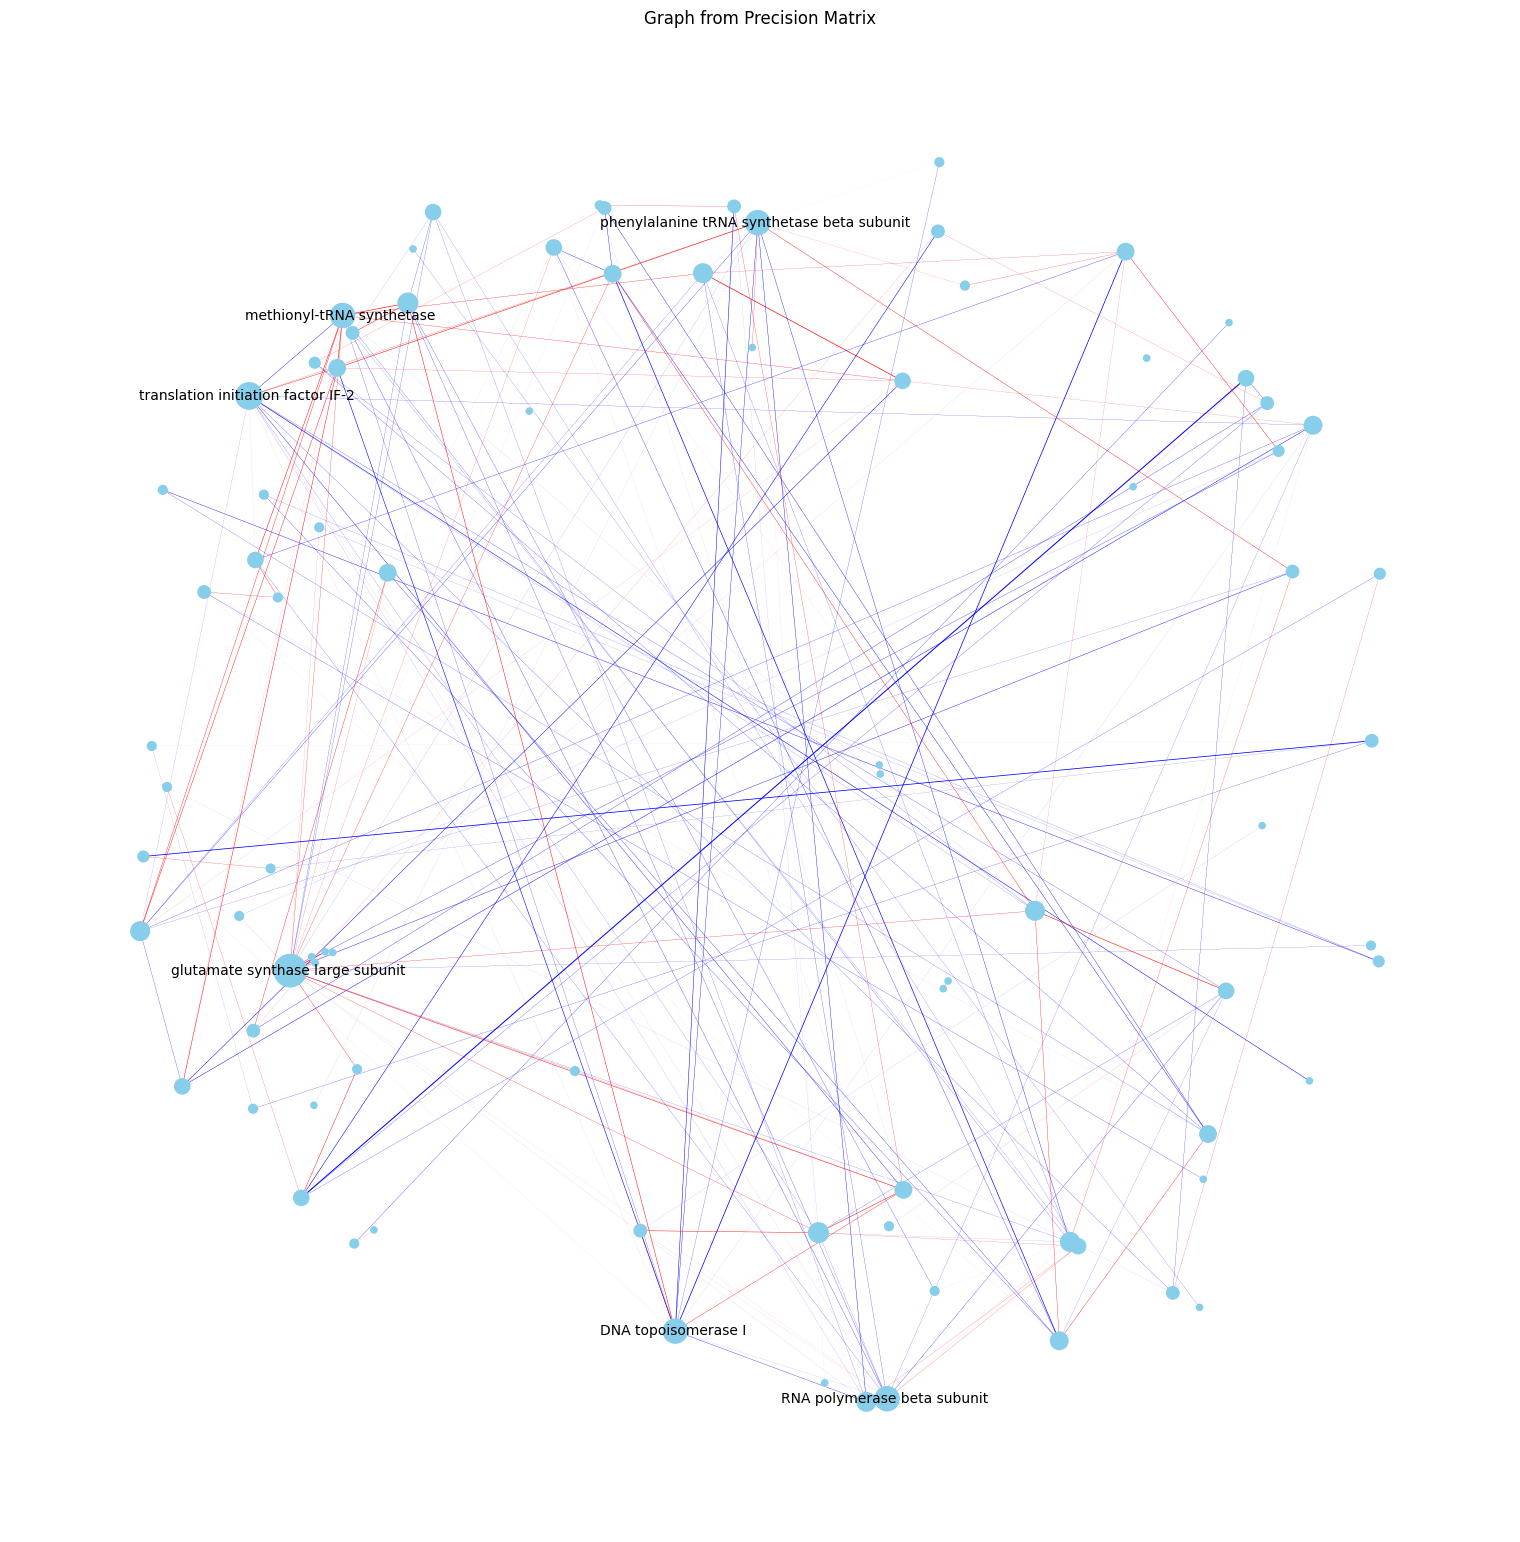

In [34]:
# Set edge colors based on weight sign
edge_colors = []
edge_widths = []
for edge in ec_G.edges(data=True):
    weight = edge[2]['weight']
    if weight > 0:
        edge_colors.append('red')  # Positive edge
    elif weight < 0:
        edge_colors.append('blue')  # Negative edge
    edge_widths.append(abs(weight)*0.01)  # Scale width based on weight

# scale the node size with the degree of the node
node_sizes = [val * 20 for (node, val) in ec_G.degree()]

# only print node names if degree is greater than 10
node_labels = {node: node if val > 10 else '' for (node, val) in ec_G.degree()}


pos = nx.spring_layout(ec_G)
plt.figure(figsize=(15, 15))
nx.draw(ec_G, pos, with_labels=True, node_size=node_sizes, node_color='skyblue', font_size=10, 
        edge_color=edge_colors, width=edge_widths, labels=node_labels)
plt.title('Graph from Precision Matrix')
plt.show()

In [102]:
node_labels = {node: node if val > 5 else '' for (node, val) in ec_G.degree()}

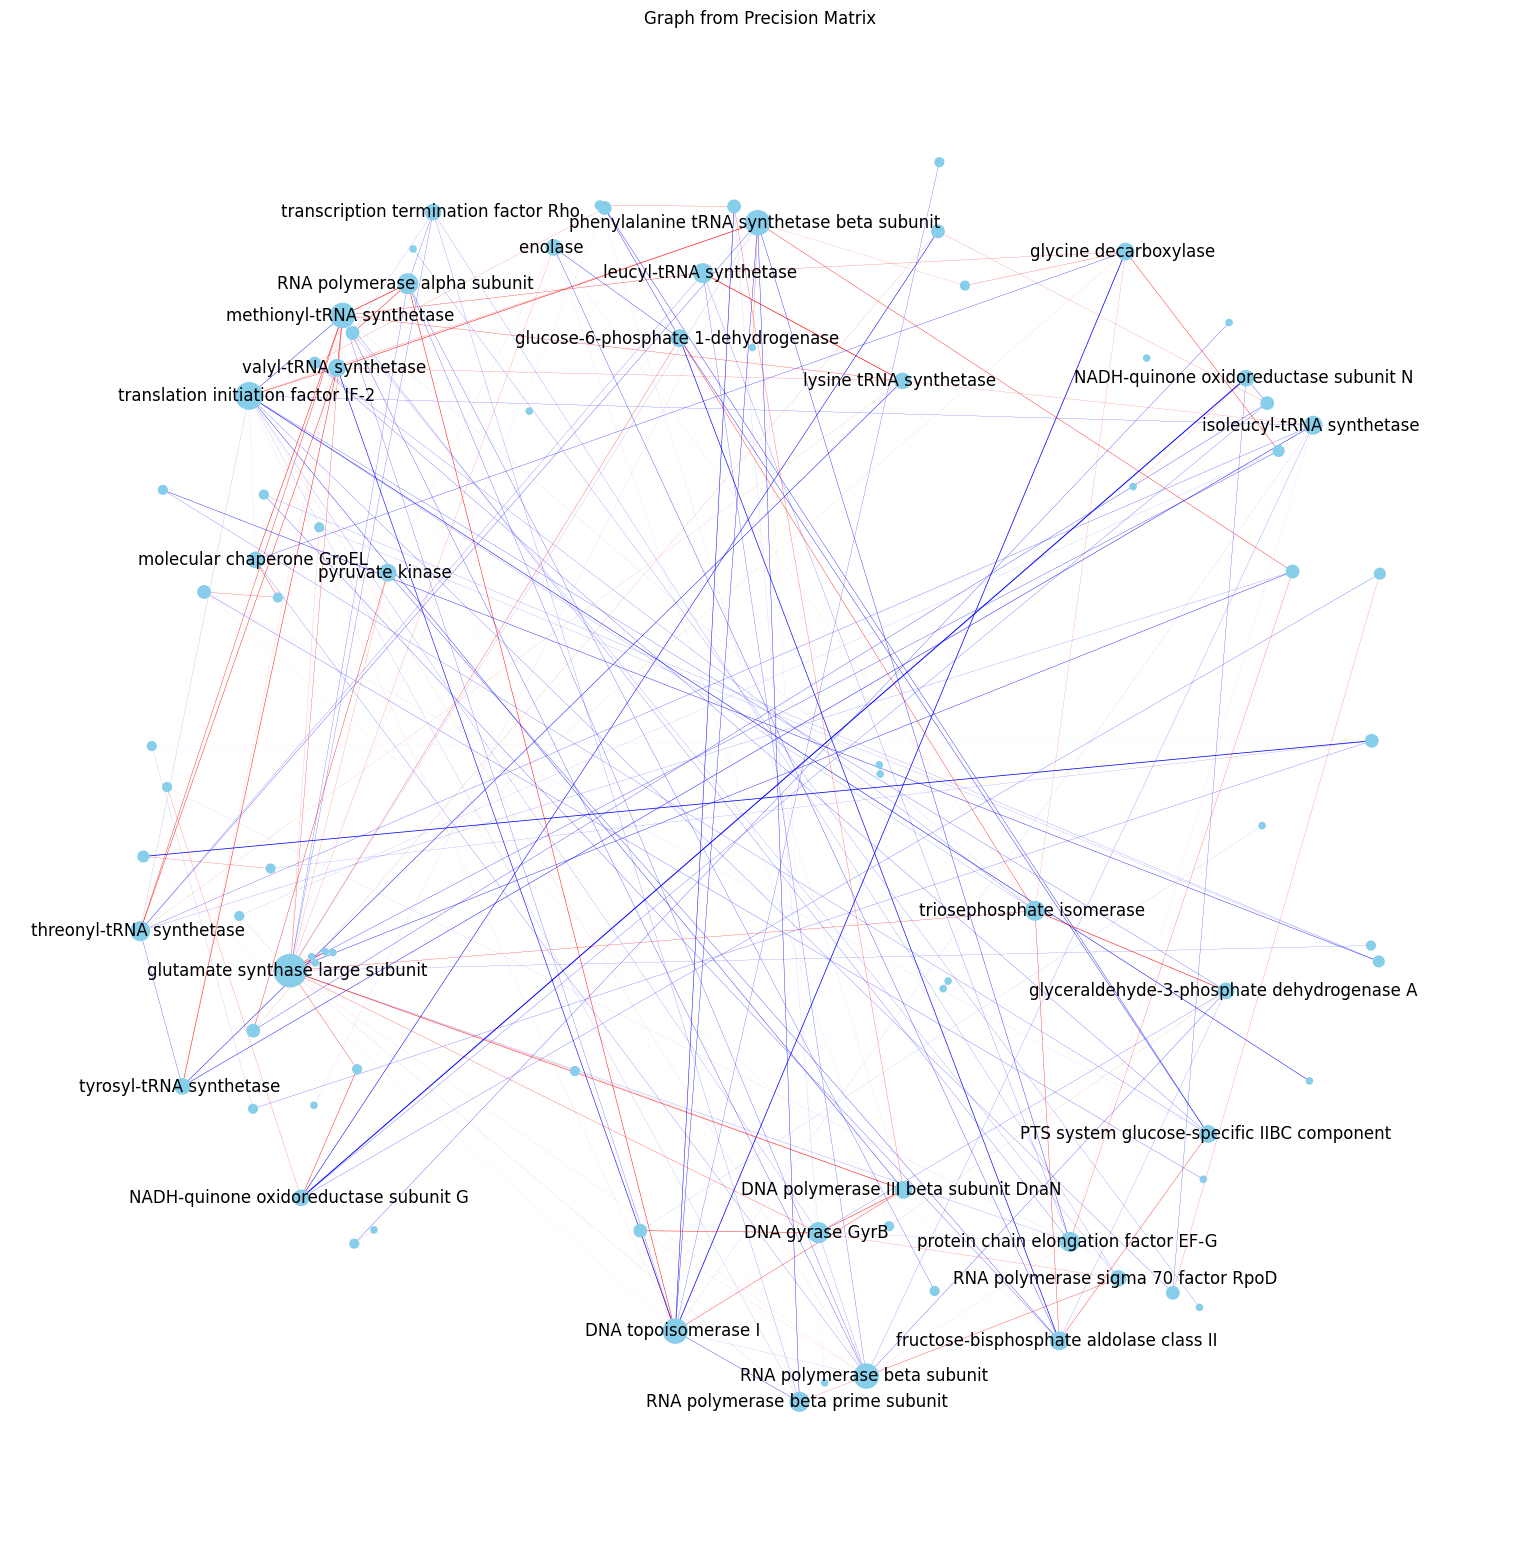

In [104]:
plt.figure(figsize=(15, 15))
nx.draw(ec_G, pos, with_labels=True, node_size=node_sizes, node_color='skyblue', font_size=12, 
        edge_color=edge_colors, width=edge_widths, labels=node_labels)
plt.title('Graph from Precision Matrix')
plt.show()

In [114]:
num_reported_interactions / non_zero_entries

0.0061162079510703364

In [96]:
len(interactions)

455

### EMP COV

In [43]:
ec_gc1_emp_cov_est = np.cov(ec_mrna_gc1.layers['sqrt_counts'].A.T, bias=True)

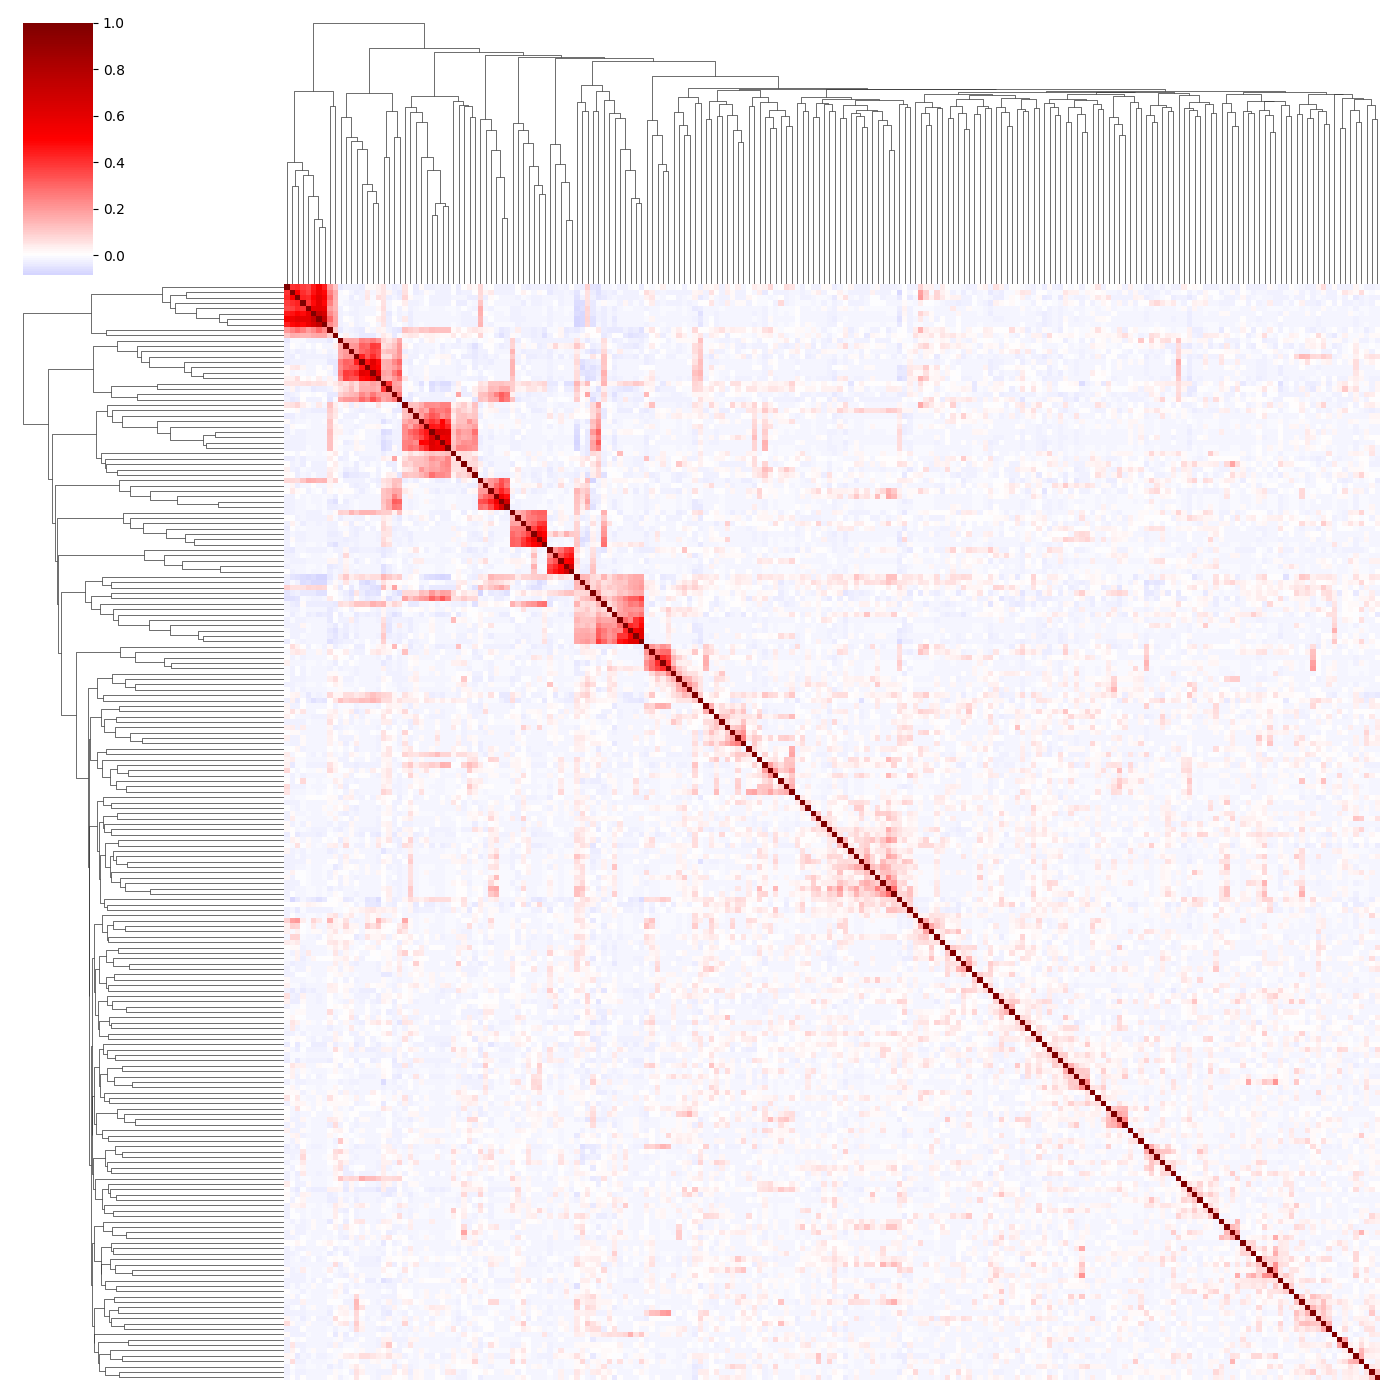

In [44]:
cm = sns.clustermap(scale_array_by_diagonal(ec_gc1_emp_cov_est), cmap='seismic', center=0, figsize=(14, 14), xticklabels=False, yticklabels=False)

In [45]:
link = linkage(y=scale_array_by_diagonal(ec_gc1_emp_cov_est), method="average", metric="euclidean")

In [46]:
print(ec_gc1_emp_cov_est.min(), ec_gc1_emp_cov_est.max())
print(scale_array_by_diagonal(ec_gc1_emp_cov_est).min(), scale_array_by_diagonal(ec_gc1_emp_cov_est).max())

-0.009204693580990223 0.38573246094044256
-0.0847950394688925 1.0000000000000002


In [47]:
ec_ggl_cov_gc1 = gg_lasso_network_analysis(N=ec_mrna_gc1.shape[0], estimate=scale_array_by_diagonal(ec_gc1_emp_cov_est))
ec_ggl_cov_gc1.create_problem(latent=False)
ec_ggl_cov_gc1.model_selection(lambda1_range=np.logspace(0, -6, 100), gamma=0.1)

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 11 iterations wi

In [48]:
ec_sol_cov_gc1 = ec_ggl_cov_gc1.P.solution.precision_

In [95]:
np.save("../data/model_selec_dicts/4S/ec_mrna_gc1_pc", ec_ggl_cov_gc1.P.__dict__)

In [101]:
np.save("../data/precision_matrices/4S/ec_mrna_gc1_pc", ec_sol_cov_gc1)

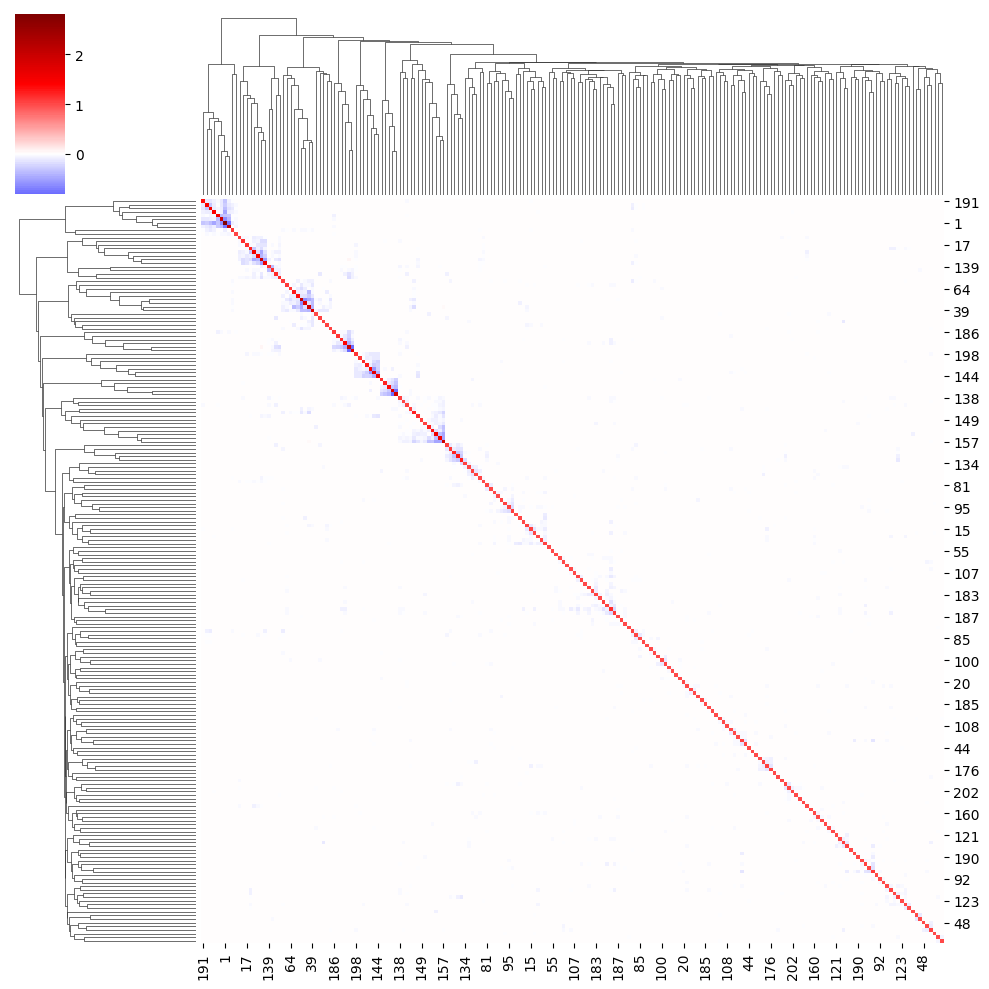

In [49]:
sns.clustermap(ec_sol_cov_gc1, cmap="seismic", col_linkage=link, row_linkage=link, figsize=(10, 10), center=0)

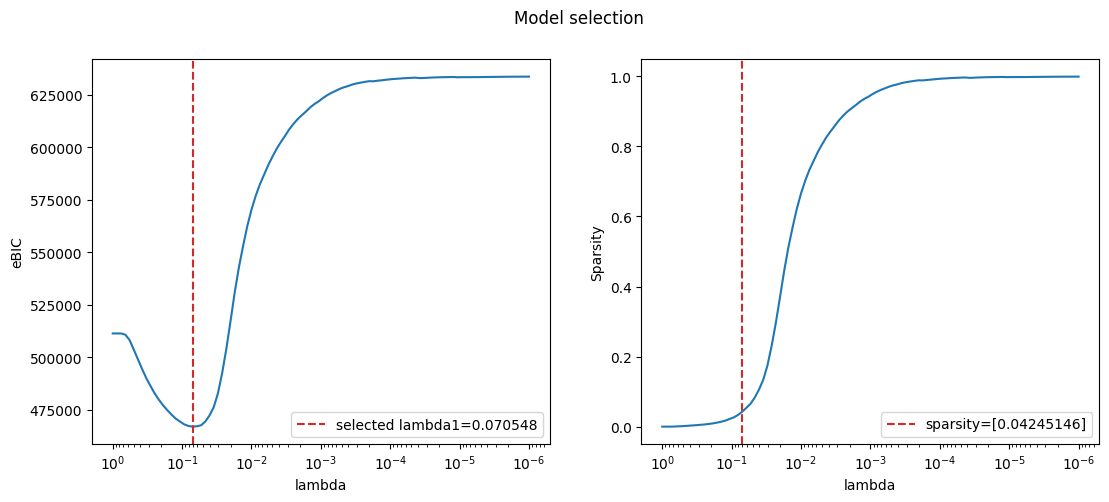

In [52]:
P_dict_gc1_mrna_cov = ec_ggl_cov_gc1.P.__dict__

lambda1_gc1_mrna_cov = P_dict_gc1_mrna_cov["reg_params"]["lambda1"]
lambda1_range = P_dict_gc1_mrna_cov["modelselect_params"]["lambda1_range"]
sparsity_gc1_mrna_cov = P_dict_gc1_mrna_cov["modelselect_stats"]["SP"]
eBIC_gc1_mrna_cov = P_dict_gc1_mrna_cov["modelselect_stats"]["BIC"][0.1]

fig, axs = plt.subplots(1, 2, figsize=(13, 5))

sns.lineplot(x=lambda1_range, y=eBIC_gc1_mrna_cov.squeeze(), ax=axs[0])
axs[0].axvline(x=lambda1_gc1_mrna_cov, ls="--", color="C3", label=f"selected lambda1={np.round(lambda1_gc1_mrna_cov, 7)}")
axs[0].set_xscale("log")
axs[0].set_xlabel("lambda")
axs[0].set_ylabel("eBIC")
axs[0].invert_xaxis()
axs[0].legend()

sns.lineplot(x=lambda1_range, y=sparsity_gc1_mrna_cov.squeeze(), ax=axs[1])
axs[1].axvline(x=lambda1_gc1_mrna_cov, ls="--", color="C3", label=f"sparsity={sparsity_gc1_mrna_cov[np.where(lambda1_range == lambda1_gc1_mrna_cov)[0][0]]}")
axs[1].set_xscale("log")
axs[1].set_xlabel("lambda")
axs[1].set_ylabel("Sparsity")
axs[1].invert_xaxis()
axs[1].legend()
plt.suptitle("Model selection")
plt.show()

In [54]:
#number of nodes
print("nodes:", ec_sol_cov_gc1.shape[0])
#number of edges
print("edges:", np.count_nonzero(np.triu(ec_sol_cov_gc1, k=1)))
#ebic value
print("ebic:", eBIC_gc1_mrna_cov[np.where(lambda1_range == lambda1_gc1_mrna_cov)[0][0]])

nodes: 204
edges: 879
ebic: [467086.12612527]


In [115]:
#get new indices of the clustermap cm
new_indices = cm.dendrogram_row.reordered_ind
#reorder the matrix
emp_cov_est_reordered = scale_array_by_diagonal(ec_gc1_emp_cov_est)[new_indices, :]
emp_cov_est_reordered = emp_cov_est_reordered[:, new_indices]
emp_cov_est_reordered.shape

(204, 204)

In [116]:
labels_full = ec_mrna_gc1.var["protein_name"].values[new_indices]
labels_full = [label.split("[")[0] for label in labels_full]
labels_full[0]

'NP_313162.1 anaerobic fumarate reductase catalytic and NAD/flavoprotein subunit '

In [117]:
labels_prot = [label.split(" ")[0] for label in labels_full]
labels_prot[0]

'NP_313162.1'

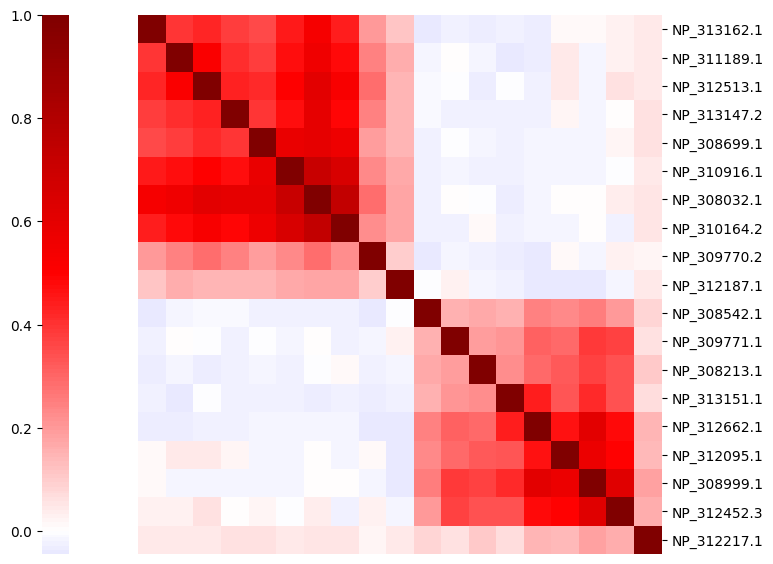

In [146]:
#plot the reordered matrix
plt.figure(figsize=(9, 7))
sns.heatmap(emp_cov_est_reordered[:19, :19], cmap='seismic', center=0, xticklabels=False, yticklabels=labels_prot[:19], cbar=True, cbar_kws={"location": "left"})
#labels should be on the right side
plt.tick_params(axis='y', right=True, left= False, labelright=True, labelleft=False, labelrotation=0)
plt.show()

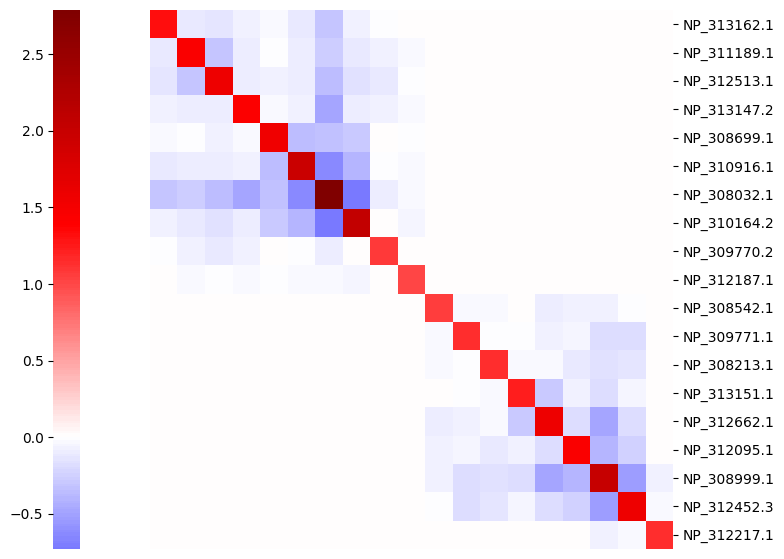

In [147]:
ec_sol_cov_gc1_reord = ec_sol_cov_gc1[new_indices, :]
ec_sol_cov_gc1_reord = ec_sol_cov_gc1_reord[:, new_indices]
#plot the reordered matrix
plt.figure(figsize=(9, 7))
sns.heatmap(ec_sol_cov_gc1_reord[:19, :19], cmap='seismic', center=0, xticklabels=False, yticklabels=labels_prot[:19], cbar=True, cbar_kws={"location": "left"})
#labels should be on the right side
plt.tick_params(axis='y', right=True, left= False, labelright=True, labelleft=False, labelrotation=0)
plt.show()

In [23]:
for i in [" ".join(label.split(" ")[1:-1]) for label in labels_full]:
    print(i)

anaerobic fumarate reductase catalytic and NAD/flavoprotein subunit
NADH-quinone oxidoreductase subunit L
glycerol-3-phosphate dehydrogenase
aspartate ammonia-lyase
cell wall shape-determining protein
peptidase
hypothetical protein ECs_0005
transcriptional repressor
oligopeptide ABC transporter periplasmic binding protein
RNA polymerase alpha subunit
multidrug efflux system protein
oligopeptide ABC transporter permease
DNA polymerase III alpha subunit DnaE
molecular chaperone GroEL
recombination protein RecF
UDP-N-acetylglucosamine 1-carboxyvinyltransferase
amino acid ABC transporter permease
KDO phosphoethanolamine transferase
translation elongation factor EF-Tu 1
translation elongation factor EF-Tu 1
DNA topoisomerase I
glycine decarboxylase
hydrogenase 2 large subunit
threonyl-tRNA synthetase
formate dehydrogenase subunit alpha
triosephosphate isomerase
shikimate kinase I
L,D-transpeptidase-related protein
aspartyl-tRNA synthetase

glutathione ABC transporter ATP-binding protein
rib

In [125]:
n = ec_mrna_gc1.shape[1]
non_zero_entries = np.count_nonzero(ec_sol_cov_gc1)
num_reported_interactions = 0
ec_G_cov = nx.Graph()

for i in range(n):
    for j in range(i+1, n):
        if ec_sol_cov_gc1[i, j] != 0:
            a = ec_mrna_gc1.var.iloc[i]["string_id"]
            b = ec_mrna_gc1.var.iloc[j]["string_id"]
            
            interaction_ab = interactions.loc[(interactions["node1_string_id"] == a) & (interactions["node2_string_id"] == b)]["combined_score"]
            interaction_ba = interactions.loc[(interactions["node1_string_id"] == b) & (interactions["node2_string_id"] == a)]["combined_score"]
            
            if len(interaction_ab) > 0 or len(interaction_ba) > 0:
                print(f"{ec_mrna_gc1.var.iloc[i]['protein_name_short']} - {ec_mrna_gc1.var.iloc[j]['protein_name_short']}")
                num_reported_interactions += 1

                ec_G_cov.add_node(ec_mrna_gc1.var.iloc[i]['protein_name_short'])
                ec_G_cov.add_node(ec_mrna_gc1.var.iloc[j]['protein_name_short'])
                ec_G_cov.add_edge(ec_mrna_gc1.var.iloc[i]['protein_name_short'], ec_mrna_gc1.var.iloc[j]['protein_name_short'], weight=ec_sol_cov_gc1[i, j])

isoleucyl-tRNA synthetase  - tyrosyl-tRNA synthetase 
cytochrome d terminal oxidase subunit II  - NADH-quinone oxidoreductase subunit G 
DNA topoisomerase I  - phenylalanine tRNA synthetase beta subunit 
DNA topoisomerase I  - glycine decarboxylase 
DNA topoisomerase I  - RNA polymerase beta prime subunit 
phenylalanine tRNA synthetase beta subunit  - protein chain elongation factor EF-G 
phenylalanine tRNA synthetase beta subunit  - RNA polymerase beta prime subunit 
glucose-6-phosphate 1-dehydrogenase  - enolase 
glucose-6-phosphate 1-dehydrogenase  - fructose-bisphosphate aldolase class II 
NADH-quinone oxidoreductase subunit N  - NADH-quinone oxidoreductase subunit G 
glycine decarboxylase  - molecular chaperone GroEL 
RNA polymerase beta subunit  - molecular chaperone GroEL 


In [129]:
# give me the value of the edge between enolase and glucose-6-phosphate 1-dehydrogenase
ec_G_cov['enolase ']['glucose-6-phosphate 1-dehydrogenase ']

{'weight': -5.68671729431619e-05}

In [142]:
edge_widths[-3] = 0.15

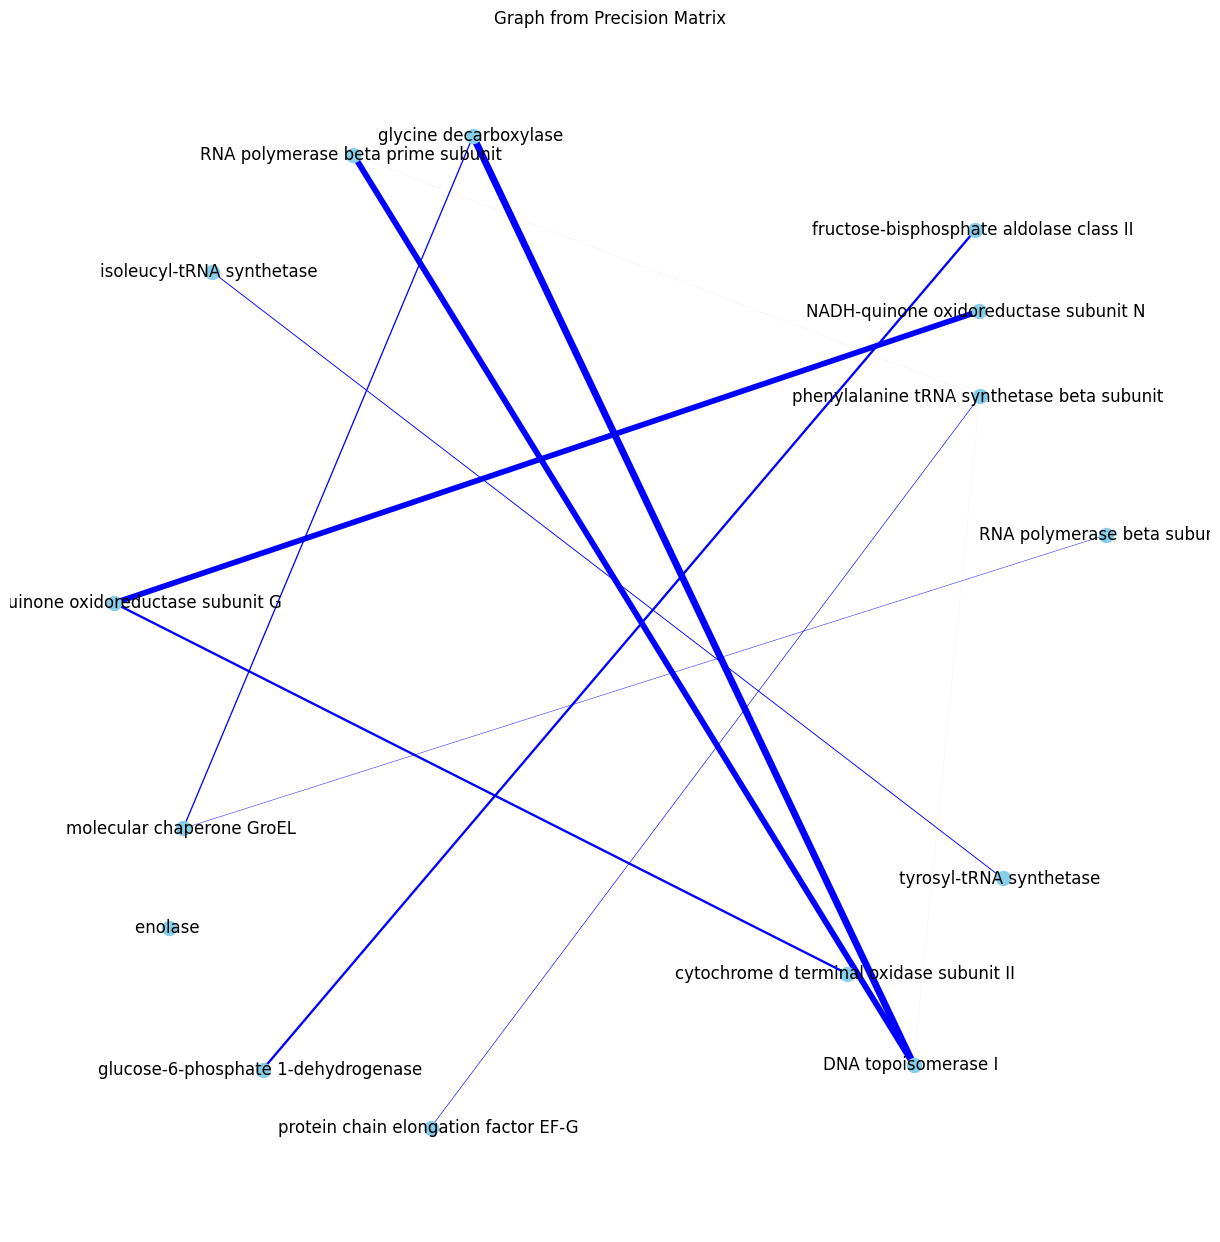

In [137]:
# Set edge colors based on weight sign
edge_colors = []
edge_widths = []
for edge in ec_G_cov.edges(data=True):
    weight = edge[2]['weight']
    if weight > 0:
        edge_colors.append('red')  # Positive edge
    elif weight < 0:
        edge_colors.append('blue')  # Negative edge
    edge_widths.append(abs(weight)*50)  # Scale width based on weight

pos = nx.spring_layout(ec_G_cov)
plt.figure(figsize=(12, 12))
nx.draw(ec_G_cov, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=12, 
        edge_color=edge_colors, width=edge_widths)
plt.title('Graph from Precision Matrix')
plt.show()

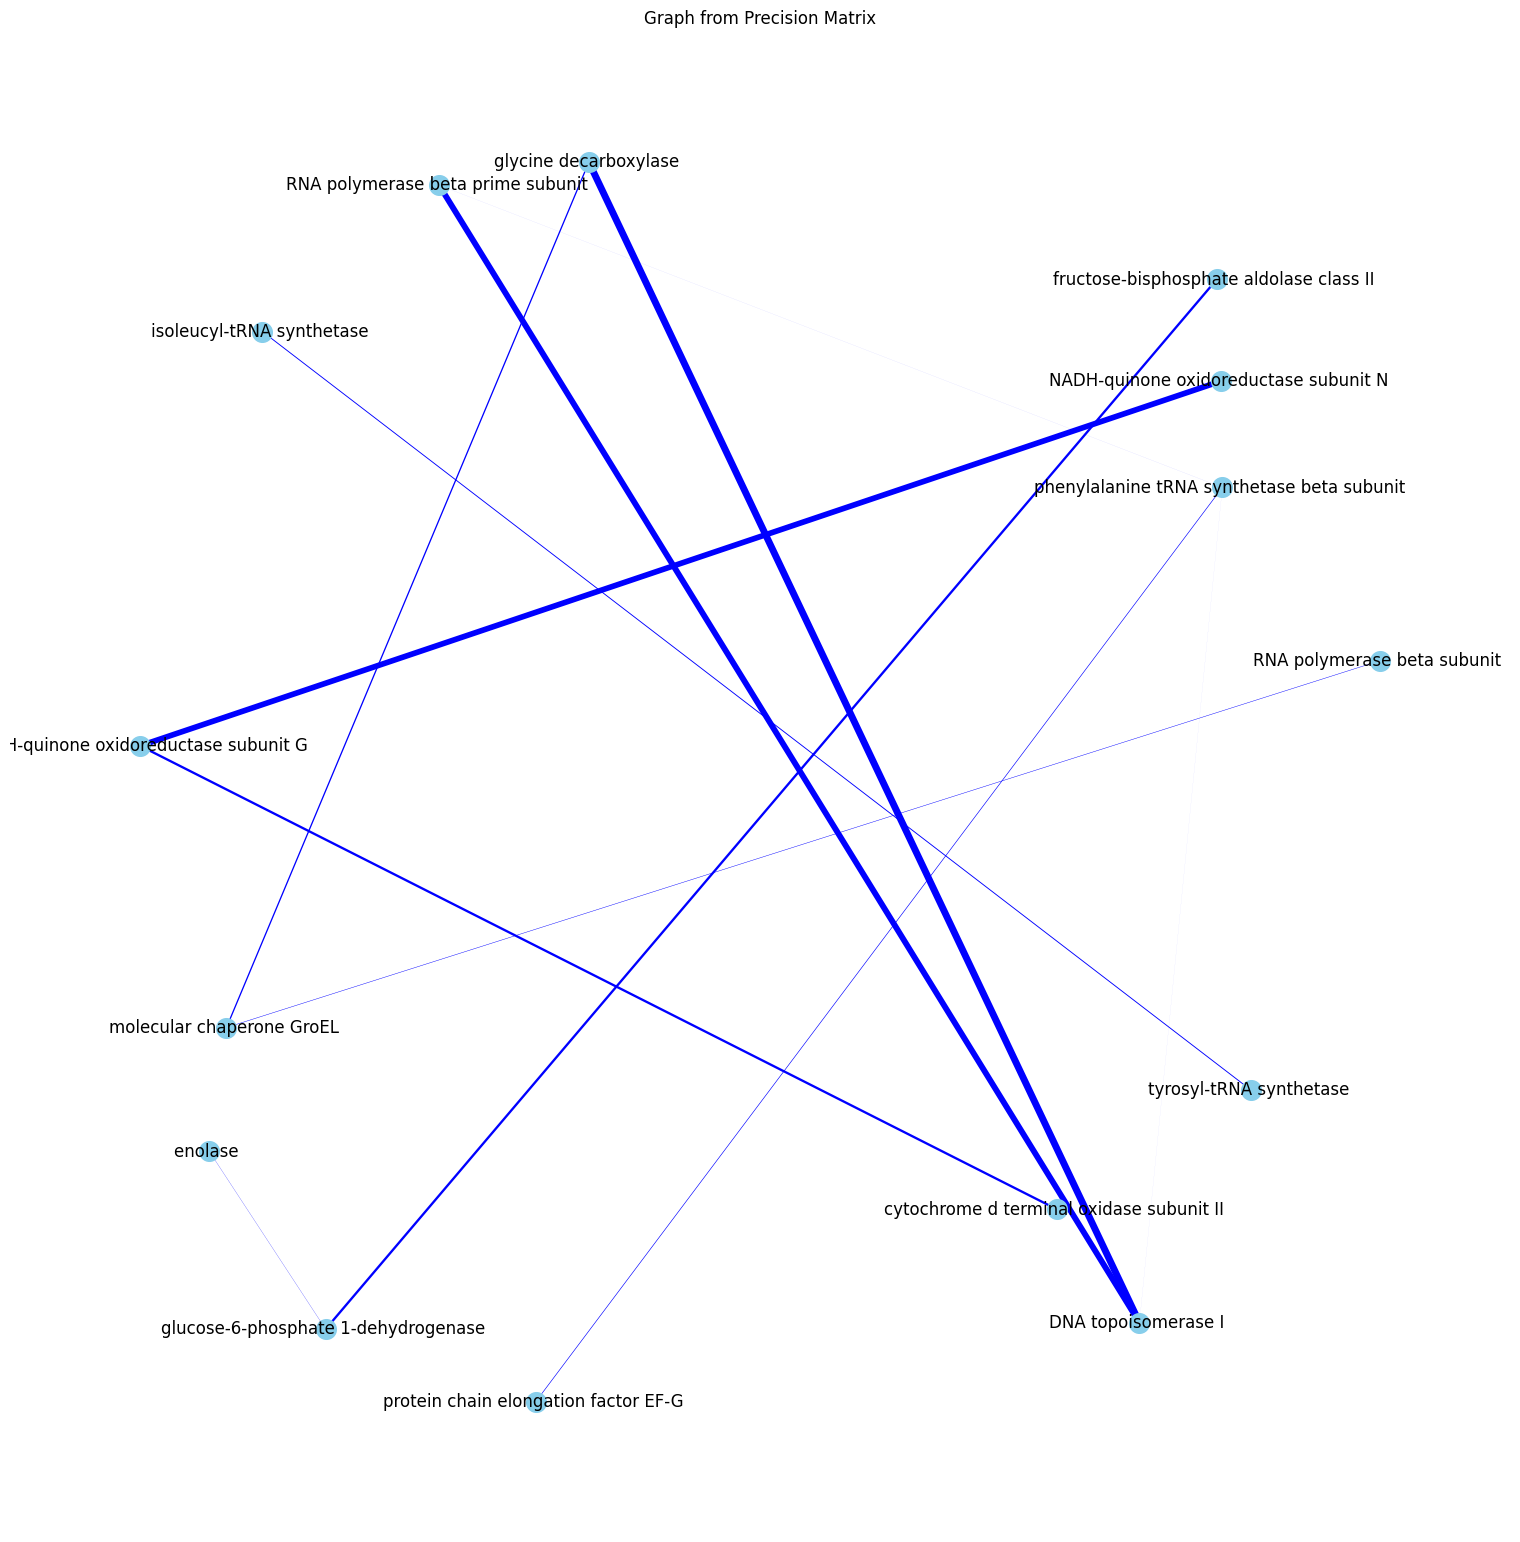

In [144]:
plt.figure(figsize=(15, 15))
nx.draw(ec_G_cov, pos, with_labels=True, node_size=200, node_color='skyblue', font_size=12, 
        edge_color=edge_colors, width=edge_widths)
plt.title('Graph from Precision Matrix')
plt.show()

In [ ]:
node_labels = {node: node if val > 5 else '' for (node, val) in ec_G.degree()}

plt.figure(figsize=(15, 15))
nx.draw(ec_G, pos, with_labels=True, node_size=node_sizes, node_color='skyblue', font_size=12, 
        edge_color=edge_colors, width=edge_widths, labels=node_labels)
plt.title('Graph from Precision Matrix')
plt.show()

In [79]:
num_reported_interactions

27

In [80]:
num_reported_interactions / non_zero_entries

0.013761467889908258

### rRNA GC1: latentcor + GGL

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


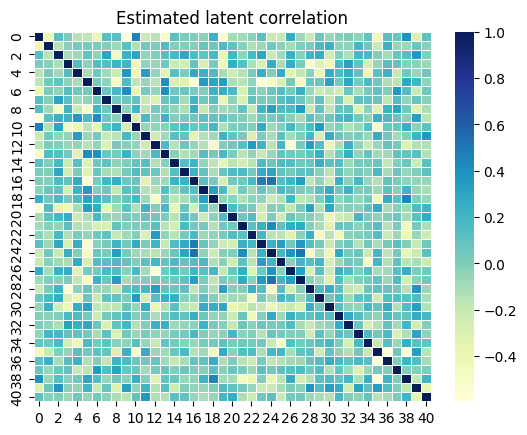

In [55]:
tps = ['tru' for i in range(ec_rrna_gc1.shape[1])]
ec_est_rrna_gc1 = latentcor(ec_rrna_gc1.layers['sqrt_counts'].A, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=True)

In [11]:
np.save("../data/latent_est/4S/ec_est_gc1_rrna.npy", ec_est_rrna_gc1)

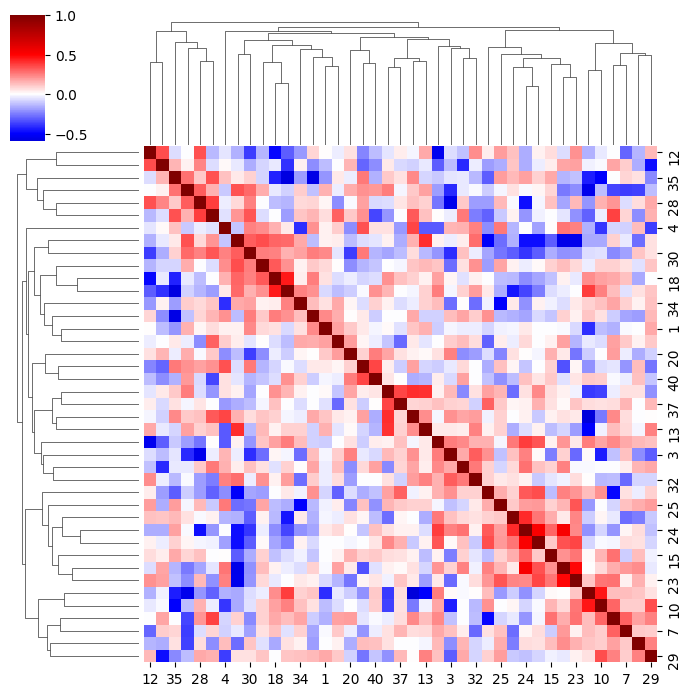

In [56]:
sns.clustermap(ec_est_rrna_gc1['R'], cmap='seismic', figsize=(7, 7), center=0)

In [57]:
ec_rrna_gc1_link = linkage(y=ec_est_rrna_gc1['R'], method="average", metric="euclidean")

In [66]:
ec_rrna_gc1_lc = gg_lasso_network_analysis(N=ec_rrna_gc1.shape[0], estimate=ec_est_rrna_gc1)
ec_rrna_gc1_lc.create_problem(S_col="R", latent=False)
ec_rrna_gc1_lc.model_selection(lambda1_range=np.logspace(0, -6, 100), gamma=0.1)

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 29 iterations wi

In [67]:
ec_sol_gc1_rrna = ec_rrna_gc1_lc.P.solution.precision_

In [96]:
np.save("../data/model_selec_dicts/4S/ec_rrna_gc1_lc", ec_rrna_gc1_lc.P.__dict__)

In [103]:
np.save("../data/precision_matrices/4S/ec_rrna_gc1_lc", ec_sol_gc1_rrna)

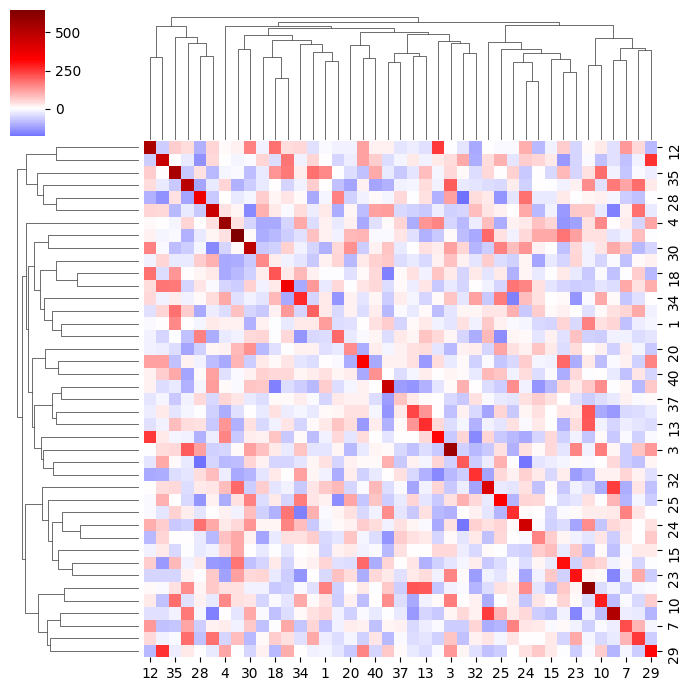

In [68]:
sns.clustermap(ec_sol_gc1_rrna, cmap="seismic", col_linkage=ec_rrna_gc1_link, row_linkage=ec_rrna_gc1_link, figsize=(7, 7), center=0)

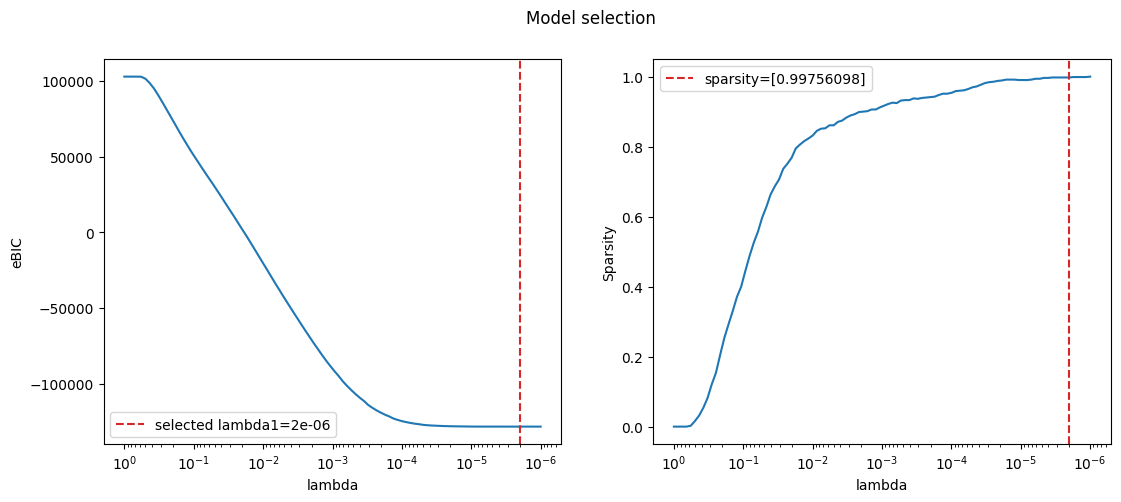

In [69]:
P_dict_gc1_rrna = ec_rrna_gc1_lc.P.__dict__

lambda1_gc1_rrna = P_dict_gc1_rrna["reg_params"]["lambda1"]
lambda1_range = P_dict_gc1_rrna["modelselect_params"]["lambda1_range"]
sparsity_gc1_rrna = P_dict_gc1_rrna["modelselect_stats"]["SP"]
eBIC_gc1_rrna = P_dict_gc1_rrna["modelselect_stats"]["BIC"][0.1]

fig, axs = plt.subplots(1, 2, figsize=(13, 5))

sns.lineplot(x=lambda1_range, y=eBIC_gc1_rrna.squeeze(), ax=axs[0])
axs[0].axvline(x=lambda1_gc1_rrna, ls="--", color="C3", label=f"selected lambda1={np.round(lambda1_gc1_rrna, 7)}")
axs[0].set_xscale("log")
axs[0].set_xlabel("lambda")
axs[0].set_ylabel("eBIC")
axs[0].invert_xaxis()
axs[0].legend()

sns.lineplot(x=lambda1_range, y=sparsity_gc1_rrna.squeeze(), ax=axs[1])
axs[1].axvline(x=lambda1_gc1_rrna, ls="--", color="C3", label=f"sparsity={sparsity_gc1_rrna[np.where(lambda1_range == lambda1_gc1_rrna)[0][0]]}")
axs[1].set_xscale("log")
axs[1].set_xlabel("lambda")
axs[1].set_ylabel("Sparsity")
axs[1].invert_xaxis()
axs[1].legend()
plt.suptitle("Model selection")
plt.show()

In [70]:
#number of nodes
print("nodes:", ec_sol_gc1_rrna.shape[0])
#number of edges
print("edges:", np.count_nonzero(np.triu(ec_sol_gc1_rrna, k=1)))
#ebic value
print("ebic:", eBIC_gc1_rrna[np.where(lambda1_range == lambda1_gc1_rrna)[0][0]])

nodes: 41
edges: 818
ebic: [-128486.55117937]


### Fig all

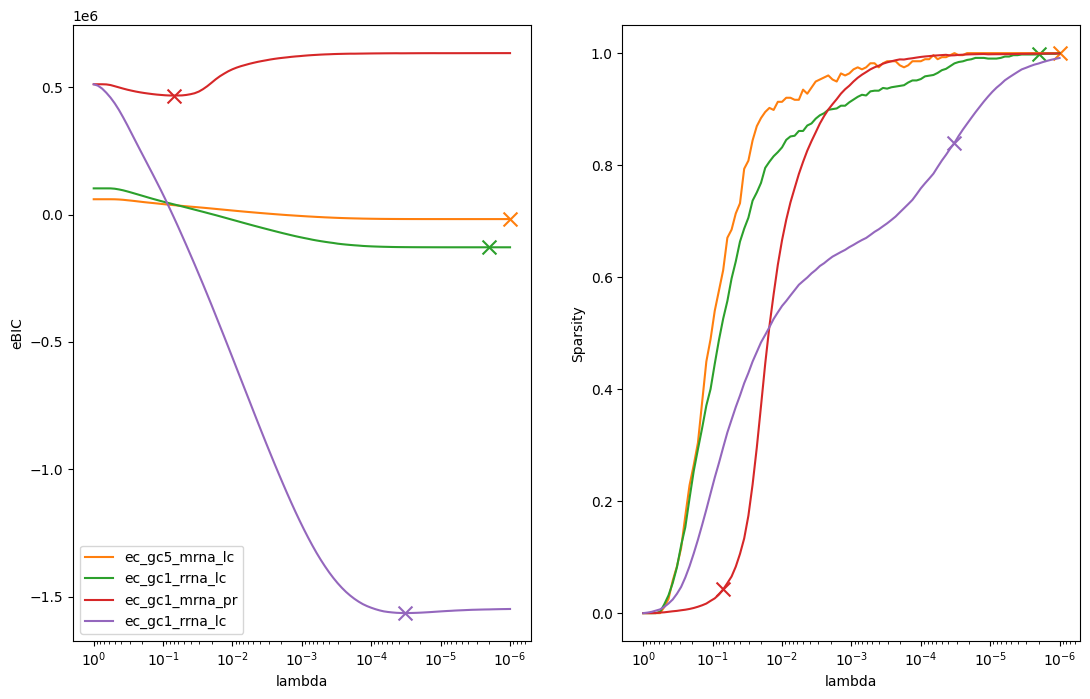

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(13, 8))

sns.lineplot(x=lambda1_range, y=eBIC_gc5_mrna.squeeze(), color="C1", ax=axs[0], label="ec_gc5_mrna_lc")
sns.lineplot(x=lambda1_range, y=eBIC_gc1_rrna.squeeze(), color="C2", ax=axs[0], label="ec_gc1_rrna_lc")
sns.lineplot(x=lambda1_range, y=eBIC_gc1_mrna_cov.squeeze(), color="C3", ax=axs[0], label="ec_gc1_mrna_pr")
sns.lineplot(x=lambda1_range, y=eBIC_gc1_mrna.squeeze(), color="C4", ax=axs[0], label="ec_gc1_rrna_lc")

#draw a cross at the selected lambda1 values
axs[0].scatter(lambda1_gc5_mrna, eBIC_gc5_mrna[np.where(lambda1_range == lambda1_gc5_mrna)[0][0]], color="C1", marker="x", s=100)
axs[0].scatter(lambda1_gc1_rrna, eBIC_gc1_rrna[np.where(lambda1_range == lambda1_gc1_rrna)[0][0]], color="C2", marker="x", s=100)
axs[0].scatter(lambda1_gc1_mrna_cov, eBIC_gc1_mrna_cov[np.where(lambda1_range == lambda1_gc1_mrna_cov)[0][0]], color="C3", marker="x", s=100)
axs[0].scatter(lambda1_gc1_mrna, eBIC_gc1_mrna[np.where(lambda1_range == lambda1_gc1_mrna)[0][0]], color="C4", marker="x", s=100)

axs[0].set_xscale("log")
axs[0].set_xlabel("lambda")
axs[0].set_ylabel("eBIC")
axs[0].invert_xaxis()
axs[0].legend()

sns.lineplot(x=lambda1_range, y=sparsity_gc5_mrna.squeeze(), color="C1", ax=axs[1],)
sns.lineplot(x=lambda1_range, y=sparsity_gc1_rrna.squeeze(), color="C2", ax=axs[1],)
sns.lineplot(x=lambda1_range, y=sparsity_gc1_mrna_cov.squeeze(), color="C3", ax=axs[1],)
sns.lineplot(x=lambda1_range, y=sparsity_gc1_mrna.squeeze(), color="C4", ax=axs[1],)

#draw a cross at the selected lambda1 values
axs[1].scatter(lambda1_gc5_mrna, sparsity_gc5_mrna[np.where(lambda1_range == lambda1_gc5_mrna)[0][0]], color="C1", marker="x", s=100)
axs[1].scatter(lambda1_gc1_rrna, sparsity_gc1_rrna[np.where(lambda1_range == lambda1_gc1_rrna)[0][0]], color="C2", marker="x", s=100)
axs[1].scatter(lambda1_gc1_mrna_cov, sparsity_gc1_mrna_cov[np.where(lambda1_range == lambda1_gc1_mrna_cov)[0][0]], color="C3", marker="x", s=100)
axs[1].scatter(lambda1_gc1_mrna, sparsity_gc1_mrna[np.where(lambda1_range == lambda1_gc1_mrna)[0][0]], color="C4", marker="x", s=100)

axs[1].set_xscale("log")
axs[1].set_xlabel("lambda")
axs[1].set_ylabel("Sparsity")
axs[1].invert_xaxis()